# Stroke Prediction Analysis

## 1. Goal of the Analysis

### 1.1 The goal:

- To develop a machine learning model capable of predicting the likelihood of a patient experiencing a stroke based on their demographic and clinical data.
- To identify key risk factors that significantly contribute to the probability of a stroke.
- This predictive tool aims to support medical professionals at The Johns Hopkins Hospital by enabling early identification of high-risk patients, to provide timely preventative advice, and improve emergency preparedness for patients and their families.

### 1.2 Stakeholders:

- **Medical Doctors & Clinicians**: To aid in risk assessment, personalize patient counseling, and prioritize patients for preventative interventions or closer monitoring.
- **Hospital Administration**: To potentially improve patient outcomes, optimize resource allocation for stroke prevention programs, and enhance the hospital's reputation for proactive care.
- **Patients and their Families**: To receive early warnings and guidance, empowering them to take necessary actions and be better prepared.
- **Public Health Researchers**: To gain further insights into stroke risk factors within the studied population.

### 1.3 Chosen Primary Metric: **F2-Score**

- **Rationale**: In the context of stroke prediction, failing to identify a patient who will subsequently have a stroke (a False Negative) has far more severe consequences (e.g., missed opportunity for life-saving treatment, permanent disability) than incorrectly identifying a healthy patient as high-risk (a False Positive), which might lead to additional check-ups or lifestyle advice.
- The **F2-score** is chosen as the primary metric because it weights recall twice as much as precision (beta=2), directly aligning with the critical need to minimize False Negatives and maximize the identification of true stroke cases.
- Secondary metrics will also be monitored to provide a comprehensive view of model performance:
    - **Recall** (sensitivity): To directly track the success in identifying true stroke cases.
    - **Precision**: To ensure the model's predictions are not excessively noisy.
    - **Precision-Recall AUC**: Especially useful for imbalanced datasets like this, providing a threshold-independent measure of performance in the precision-recall space.
    - **ROC-AUC** (Area Under the ROC Curve): For a general measure of the model's discriminative ability.
    - **Confusion Matrix**: To provide a detailed breakdown of true positives, false positives, true Negatives, and false Negatives.

### 1.4 Context and Dataset Description:

- The analysis utilizes the ["Stroke Prediction Dataset"](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) sourced from **Kaggle**. This dataset contains records of individuals with various attributes relevant to stroke risk.
- Attribute Information:

1) **id**: unique identifier
2) **gender**: "Male", "Female" or "Other"
3) **age**: age of the patient
4) **hypertension**: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) **heart_disease**: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) **ever_married**: "No" or "Yes"
7) **work_type**: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) **Residence_type**: "Rural" or "Urban"
9) **avg_glucose_level**: average glucose level in blood
10) **bmi**: body mass index
11) **smoking_status**: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) **stroke**: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient.

### 1.5 Main Project Outline / Key Considerations:

- **Data Quality & Preprocessing**: Addressing missing values (especially **BMI**), potential outliers, and ensuring data consistency.
- **Exploratory Data Analysis (EDA)**: Investigating feature distributions, relationships with the **stroke** outcome, and correlations between features.
- **Class Imbalance**: The **stroke** variable is expected to be imbalanced, therefore strategies to handle this (e.g., class weighting, appropriate metrics) will be employed.
- **Statistical Inference**: Conducting hypothesis tests to validate the statistical significance of potential risk factors identified during EDA.
- **Feature Engineering & Selection**: Creating new informative features and selecting the most relevant ones to improve model performance and interpretability.
- **Modeling Approach**: Training and evaluating several machine learning models, including baseline models (**Dummy, Rule-Based, Logistic Regression**) and advanced methods (RandomForest, XGBoost, LightGBM, CatBoost).
- **Hyperparameter Tuning**: Optimizing the chosen models to maximize performance on the **F2-score**.
- **Threshold Optimization**: Determining the optimal probability threshold for the selected model to maximize the **F2-score**.
- **Model Evaluation & Interpretation**: Assessing the final model on a hold-out test set and interpreting its predictions using techniques like **SHAP values**.

### 1.6 First, the libraries are imported and a consistent visual colormap for the analysis is created.

In [1]:
import os
import pickle
import sys

import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb

from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

NOTEBOOK_DIR = os.getcwd() 
PROJECT_ROOT_NB = os.path.dirname(NOTEBOOK_DIR)
SCRIPTS_DIR_NB = os.path.join(PROJECT_ROOT_NB, "scripts")
DATA_PATH_NB = os.path.join(PROJECT_ROOT_NB, "data", "raw", "healthcare-dataset-stroke-data.csv")
ARTIFACTS_DIR_NB = os.path.join(PROJECT_ROOT_NB, 'artifacts')
os.makedirs(ARTIFACTS_DIR_NB, exist_ok=True)

if SCRIPTS_DIR_NB not in sys.path:
    sys.path.append(SCRIPTS_DIR_NB)
if PROJECT_ROOT_NB not in sys.path:
    sys.path.append(PROJECT_ROOT_NB)

from utilities import (
    find_missing_values,
    find_outliers,
    plot_corr_matrix,
    impute_bmi_with_pipeline,
    check_vif,
    clean_data_for_eda,
    check_normality,
    check_equal_variance,
    t_test,
    chi_square_test,
    evaluate_model_performance,
    simple_rule_predictor,
    train_tune_evaluate_model,
    create_model_comparison_table,
    evaluate_final_model_performance,
    create_new_features,
    plot_bmi,
    plot_outliers,
    plot_feature_distributions,
    feature_importance_permutation,
    feature_importance_rfe
)

c:\Users\IT\Desktop\M3S2 task\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.figsize"] = (10, 6)
colors = ["#92c5de", "#ca0020", "#f4a582", "#0571b0"]
sns.set_theme(style="white")
sns.set_palette(sns.color_palette(colors))
pd.set_option("future.no_silent_downcasting", True)

## 2. Exploratory Data Analysis (EDA)

### 2.1 Importing the dataset and taking a look at it

In [3]:
df = pd.read_csv(DATA_PATH_NB).drop(columns=["id"])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


There seem to be 5110 entries with 11 features each.

In [4]:
display(df["gender"].value_counts())

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

Only 1 case with "Other" gender - this means it can be quite safely removed later on.

### 2.2 Checking for duplicates

In [5]:
duplicates = df[df.duplicated()]
print(f"There are {len(duplicates)} duplicated rows.")

There are 0 duplicated rows.


### 2.3 Checking for missing values

In [6]:
find_missing_values(df)

,Zeroes,Empty Strings,NaN
gender,0,0,0
age,0,0,0
hypertension,4612,0,0
heart_disease,4834,0,0
ever_married,0,0,0
work_type,0,0,0
Residence_type,0,0,0
avg_glucose_level,0,0,0
bmi,0,0,201
smoking_status,0,0,0


Zeroes in `hypertension`, `heart_disease` and `stroke` columns are valid - these are binary features, indicating "No" for these cases.

However, there are 201 missing `bmi` entries - these will have to be imputed.

### 2.4 Checking class distribution for class balance

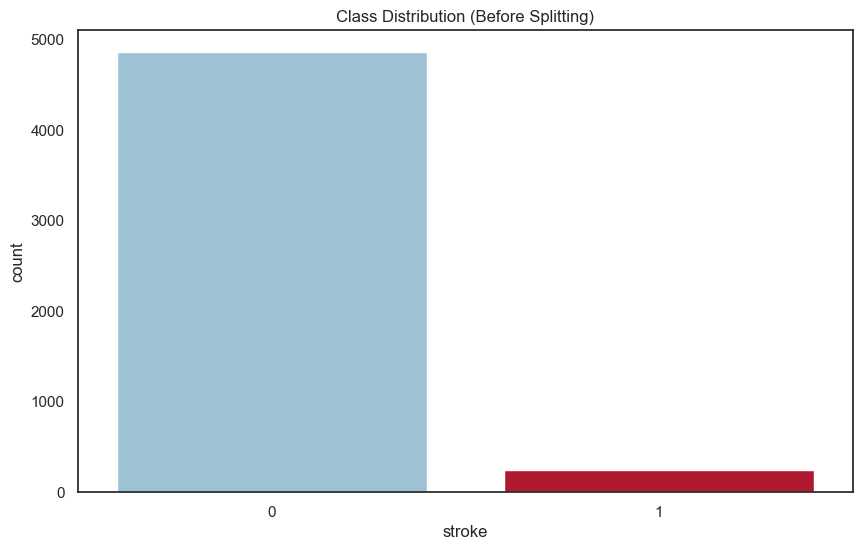

stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

In [7]:
sns.countplot(df, x="stroke", hue="stroke", legend=False)
plt.title("Class Distribution (Before Splitting)")
plt.show()

df["stroke"].value_counts(normalize=True) * 100

With 95:5 ratio of non-stroke:stroke, the dataset is very imbalanced, therefore extra care will be required for the modelling process.

### 2.5 Splitting the data and performing sanity check

To avoid data leakage, the EDA will be performed only on the non-test data split.

In [8]:
X = df.drop(columns=["stroke"])
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                random_state=42, stratify=y)

In [9]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}\n")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

print(f"Train ratio: {len(X_train) / len(X) :.2%}, Validation/Test ratio: "
      f"{len(X_test) / len(X) :.2%}")

X_train shape: (4088, 10)
y_train shape: (4088,)

X_test shape: (1022, 10)
y_test shape: (1022,)

Train ratio: 80.00%, Validation/Test ratio: 20.00%


In [10]:
print("Class distribution in full dataset:")
print(y.value_counts(normalize=True) * 100)

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True) * 100)

print("\nClass distribution in validation/test set:")
print(y_test.value_counts(normalize=True) * 100)

Class distribution in full dataset:
stroke
0    95.127202
1     4.872798
Name: proportion, dtype: float64

Class distribution in training set:
stroke
0    95.132094
1     4.867906
Name: proportion, dtype: float64

Class distribution in validation/test set:
stroke
0    95.107632
1     4.892368
Name: proportion, dtype: float64


In [11]:
overlap = set(X_train.index) & set(X_test.index)
print(f"Number of overlapping indices: {len(overlap)}")

Number of overlapping indices: 0


The data split was fine, keeping the `stroke` ratio and ensuring no indices overlap in both sets. For EDA purposes, the train data and target `stroke` are combined again.

In [12]:
train_df = X_train.join(y_train)

### 2.6 Missing `BMI` imputation

`BMI` is imputed using a simple RandomForest model, based on all features (except `bmi` and `stroke`) on training data.

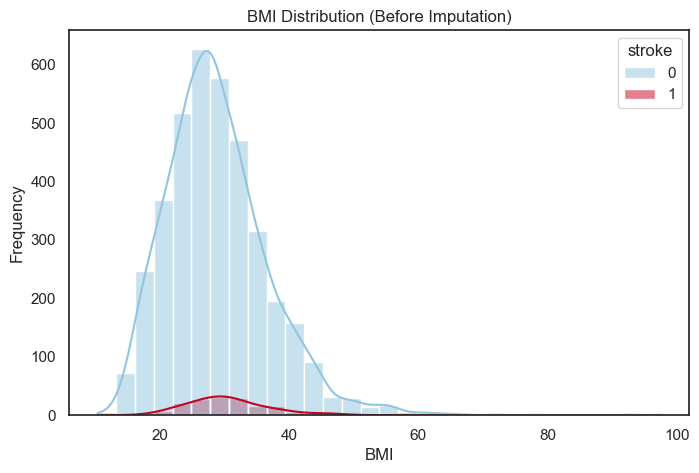

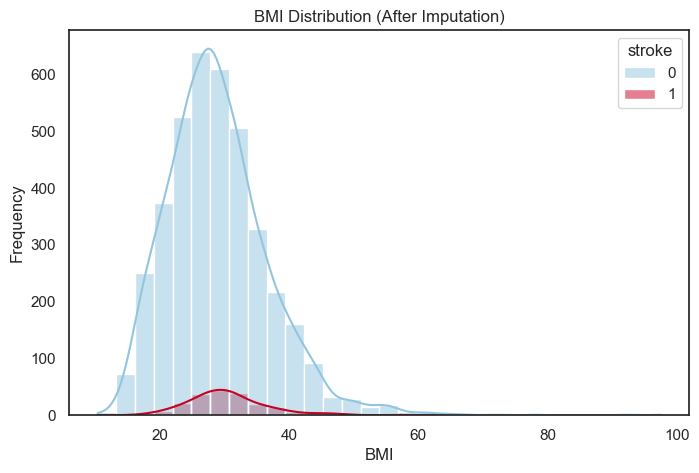

In [ ]:
plot_bmi(train_df, "BMI Distribution (Before Imputation)")

missing_bmi = train_df["bmi"].isna()
train_df = impute_bmi_with_pipeline(train_df)

plot_bmi(train_df, "BMI Distribution (After Imputation)")

The distribution seems to be the same before and after imputation. It also seems like `BMI` for `stroke` patients was more commonly missing, as its graph became taller (yet keeping same shape).

In [14]:
train_df[missing_bmi].head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2828,Male,29.0,1,0,Yes,Private,Urban,77.55,38.210,formerly smoked,0
1866,Male,10.0,0,0,No,children,Rural,99.87,20.083,formerly smoked,0
3681,Female,16.0,0,0,No,Private,Urban,89.45,23.977,Unknown,0
84,Male,58.0,0,0,Yes,Private,Urban,71.20,30.928,Unknown,1
479,Male,54.0,1,0,Yes,Private,Rural,198.69,32.398,smokes,0


Looking at the current data, the imputed `BMI` seems to be looking good.

### 2.7 Cleaning data for EDA

Cleaning the rest of the data (dropping "other" `gender` row(s), re-encoding `gender`, `ever_married`, `Residence_type` to binary for better interpretation).

In [15]:
train_df = clean_data_for_eda(train_df)
train_df.head()

,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke,gender_female,residence_type_urban
845,48.0,0,0,1,Private,69.21,33.1,never smoked,0,1,1
3744,15.0,0,0,0,Private,122.25,21.0,never smoked,0,0,0
4183,67.0,0,0,1,Self-employed,110.42,24.9,never smoked,0,1,0
3409,44.0,0,0,1,Private,65.41,24.8,smokes,0,0,1
284,14.0,0,0,0,Govt_job,82.34,31.6,Unknown,0,0,1


### 2.8 Checking feature distributions by `stroke`

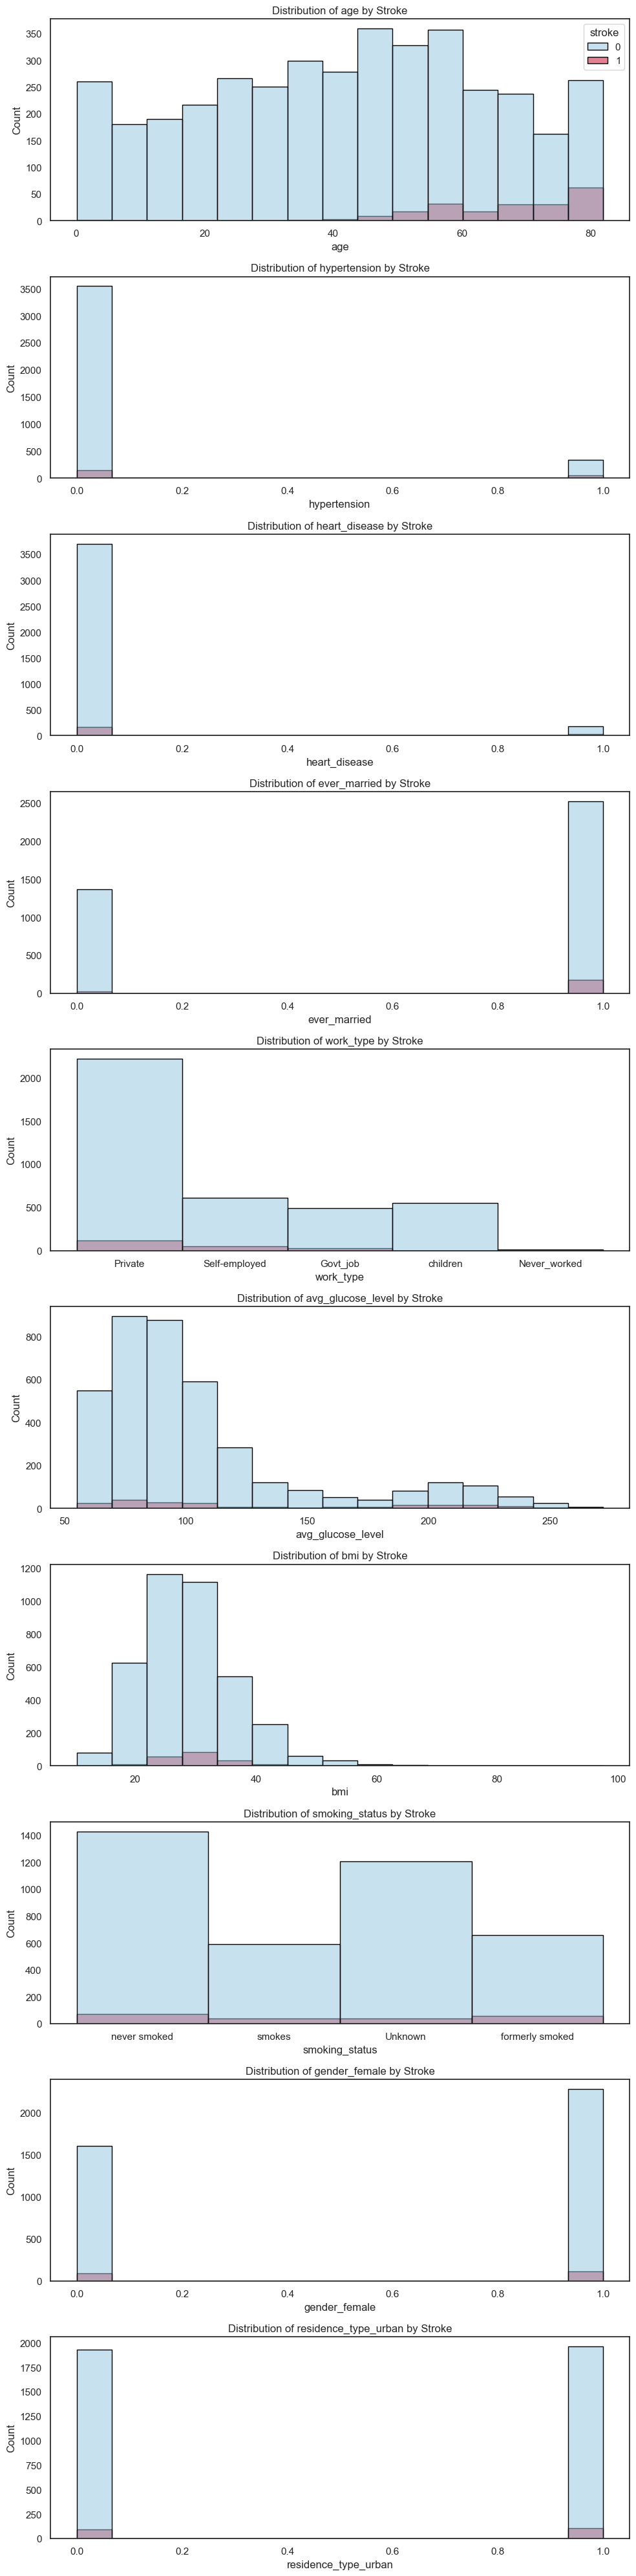

In [16]:
plot_feature_distributions(train_df)

- It seems like the `stroke` chance only becomes visible after 45 `years`, rapidly increasing after `65`.

- People with `hypertension` seem to have a higher proportion in `stroke` as well.

- `Average glucose level` seems to follow a slight bimodal distribution with a right-skew.

- `bmi` follows a normal distribution, but is very heavily right-skewed with a few cases.

- There seems to be no proportional difference in `stroke` between `genders` or `residence type`

### 2.9 Looking for outliers

In [17]:
numeric = [feature for feature in train_df if 
           train_df[feature].dtype == "float64"]
categorical = [feature for feature in train_df if 
               train_df[feature].dtype == "object"]
binary = [feature for feature in train_df if 
          train_df[feature].nunique() == 2]

In [18]:
outliers = find_outliers(train_df, numeric)
outliers
train_df.describe()

**Feature-wise Outlier Analysis**

,Feature Name,Outliers,Percentage,IQR Bounds,Flagged Values
1,avg_glucose_level,503,12.31%,"[22.01, 169.47]","[169.67, 271.74]"
2,bmi,91,2.23%,"[9.72, 47.12]","[47.30, 97.60]"


**All Outliers**

,age,avg_glucose_level,bmi
0,67.0,228.69,36.600
1,61.0,202.21,35.575
3,49.0,171.23,34.400
4,79.0,174.12,24.000
4104,62.0,212.62,35.800
...,...,...,...
4054,41.0,186.54,39.000
2016,48.0,83.34,49.300
2018,69.0,229.21,30.100
4071,57.0,98.07,50.900


,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,gender_female,residence_type_urban
count,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000,4087.000000
mean,43.357534,0.097137,0.054074,0.660631,106.308111,28.994177,0.048691,0.586004,0.506239
std,22.597950,0.296181,0.226191,0.473553,45.261486,7.832979,0.215248,0.492608,0.500022
min,0.080000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,0.000000,0.000000,77.305000,23.750000,0.000000,0.000000,0.000000
50%,45.000000,0.000000,0.000000,1.000000,91.930000,28.200000,0.000000,1.000000,1.000000
75%,61.000000,0.000000,0.000000,1.000000,114.170000,33.100000,0.000000,1.000000,1.000000
max,82.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000,1.000000,1.000000


As seen in the previous distributions, `bmi` and `avg_glucose_level` were right-skewed.

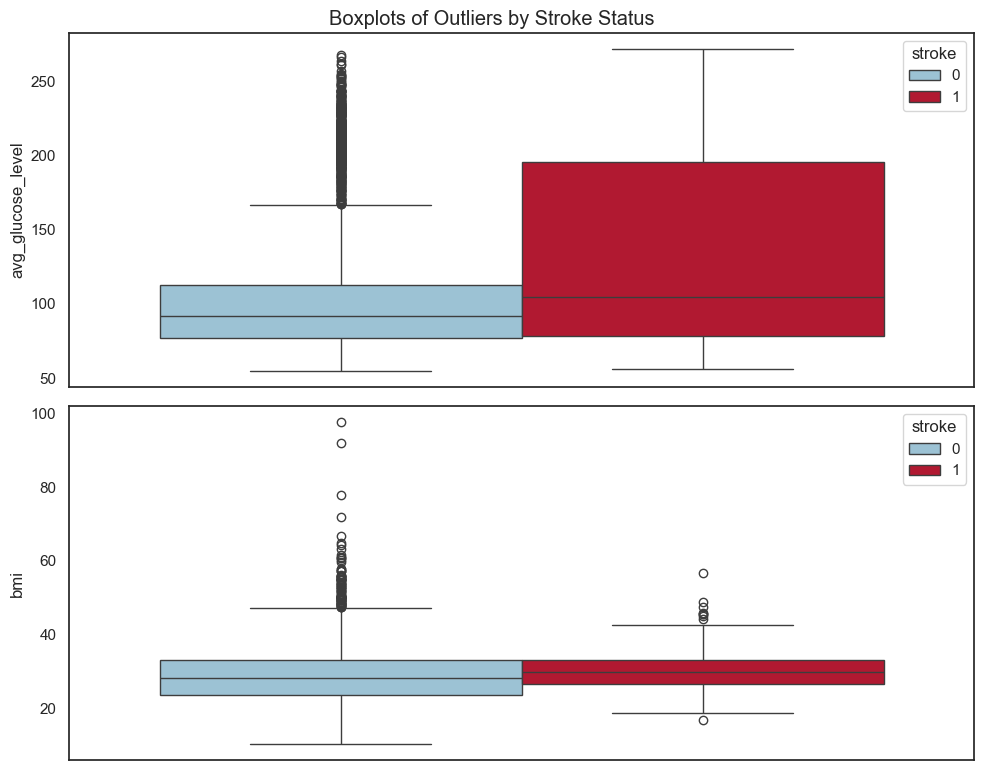

In [19]:
outlier_cols = ["avg_glucose_level","bmi"]
plot_outliers(train_df, outlier_cols)

- Patients who had a `stroke` tend to have much higher and more spread out `average glucose levels` compared to those who didn't. The entire red box is above the typical range for non-stroke patients.
- `Non-stroke` patients mostly have lower `glucose levels`, though there are many high outliers in this group too.

- For both groups, there's a wide range of `BMI` values, with many high outliers, especially for `non-stroke` patients.
- Patients who had a `stroke` appear to have a slightly higher median `BMI` than those who didn't. However, the boxes themselves overlap a lot, meaning many stroke and non-stroke patients share similar BMI ranges.

During the modelling stage, the data will have to be adjusted for the existence of outliers (using log scale).

### 2.10 Checking the correlations between features

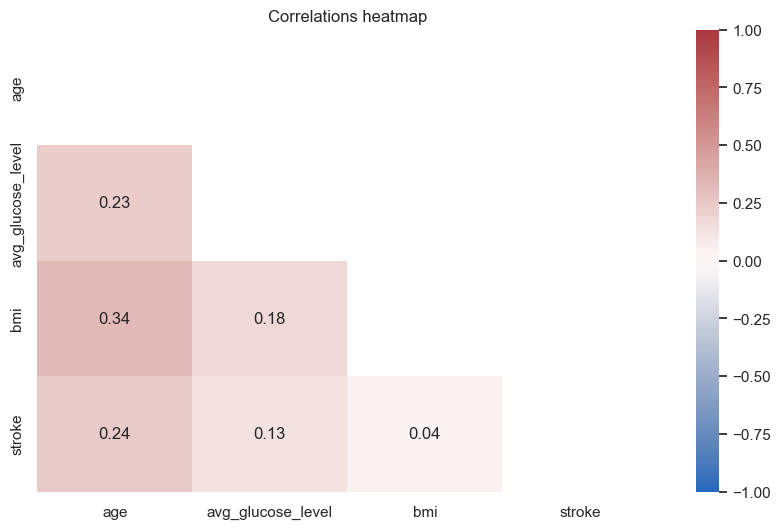

In [20]:
plot_corr_matrix(train_df[numeric+["stroke"]])

| Relationship                | Correlation | Interpretation                                                                                       |
| --------------------------- | ----------- | ---------------------------------------------------------------------------------------------------- |
| avg_glucose_level and age   | 0.23        | Mild positive correlation – older individuals tend to have slightly higher average glucose levels.   |
| bmi and age                 | 0.33        | Moderate positive correlation – BMI tends to increase with age.                                      |
| bmi and avg_glucose level   | 0.17        | Weak positive correlation – people with higher glucose levels may also have slightly higher BMI.     |
| stroke and age              | 0.24        | Mild positive correlation – older individuals have a higher likelihood of stroke.                    |
| stroke and avg_glucose_level| 0.13        | Weak positive correlation – higher glucose levels are slightly associated with stroke occurrence.    |
| stroke and bmi              | 0.04        | Very weak correlation – BMI is barely associated with stroke in this dataset.                        |

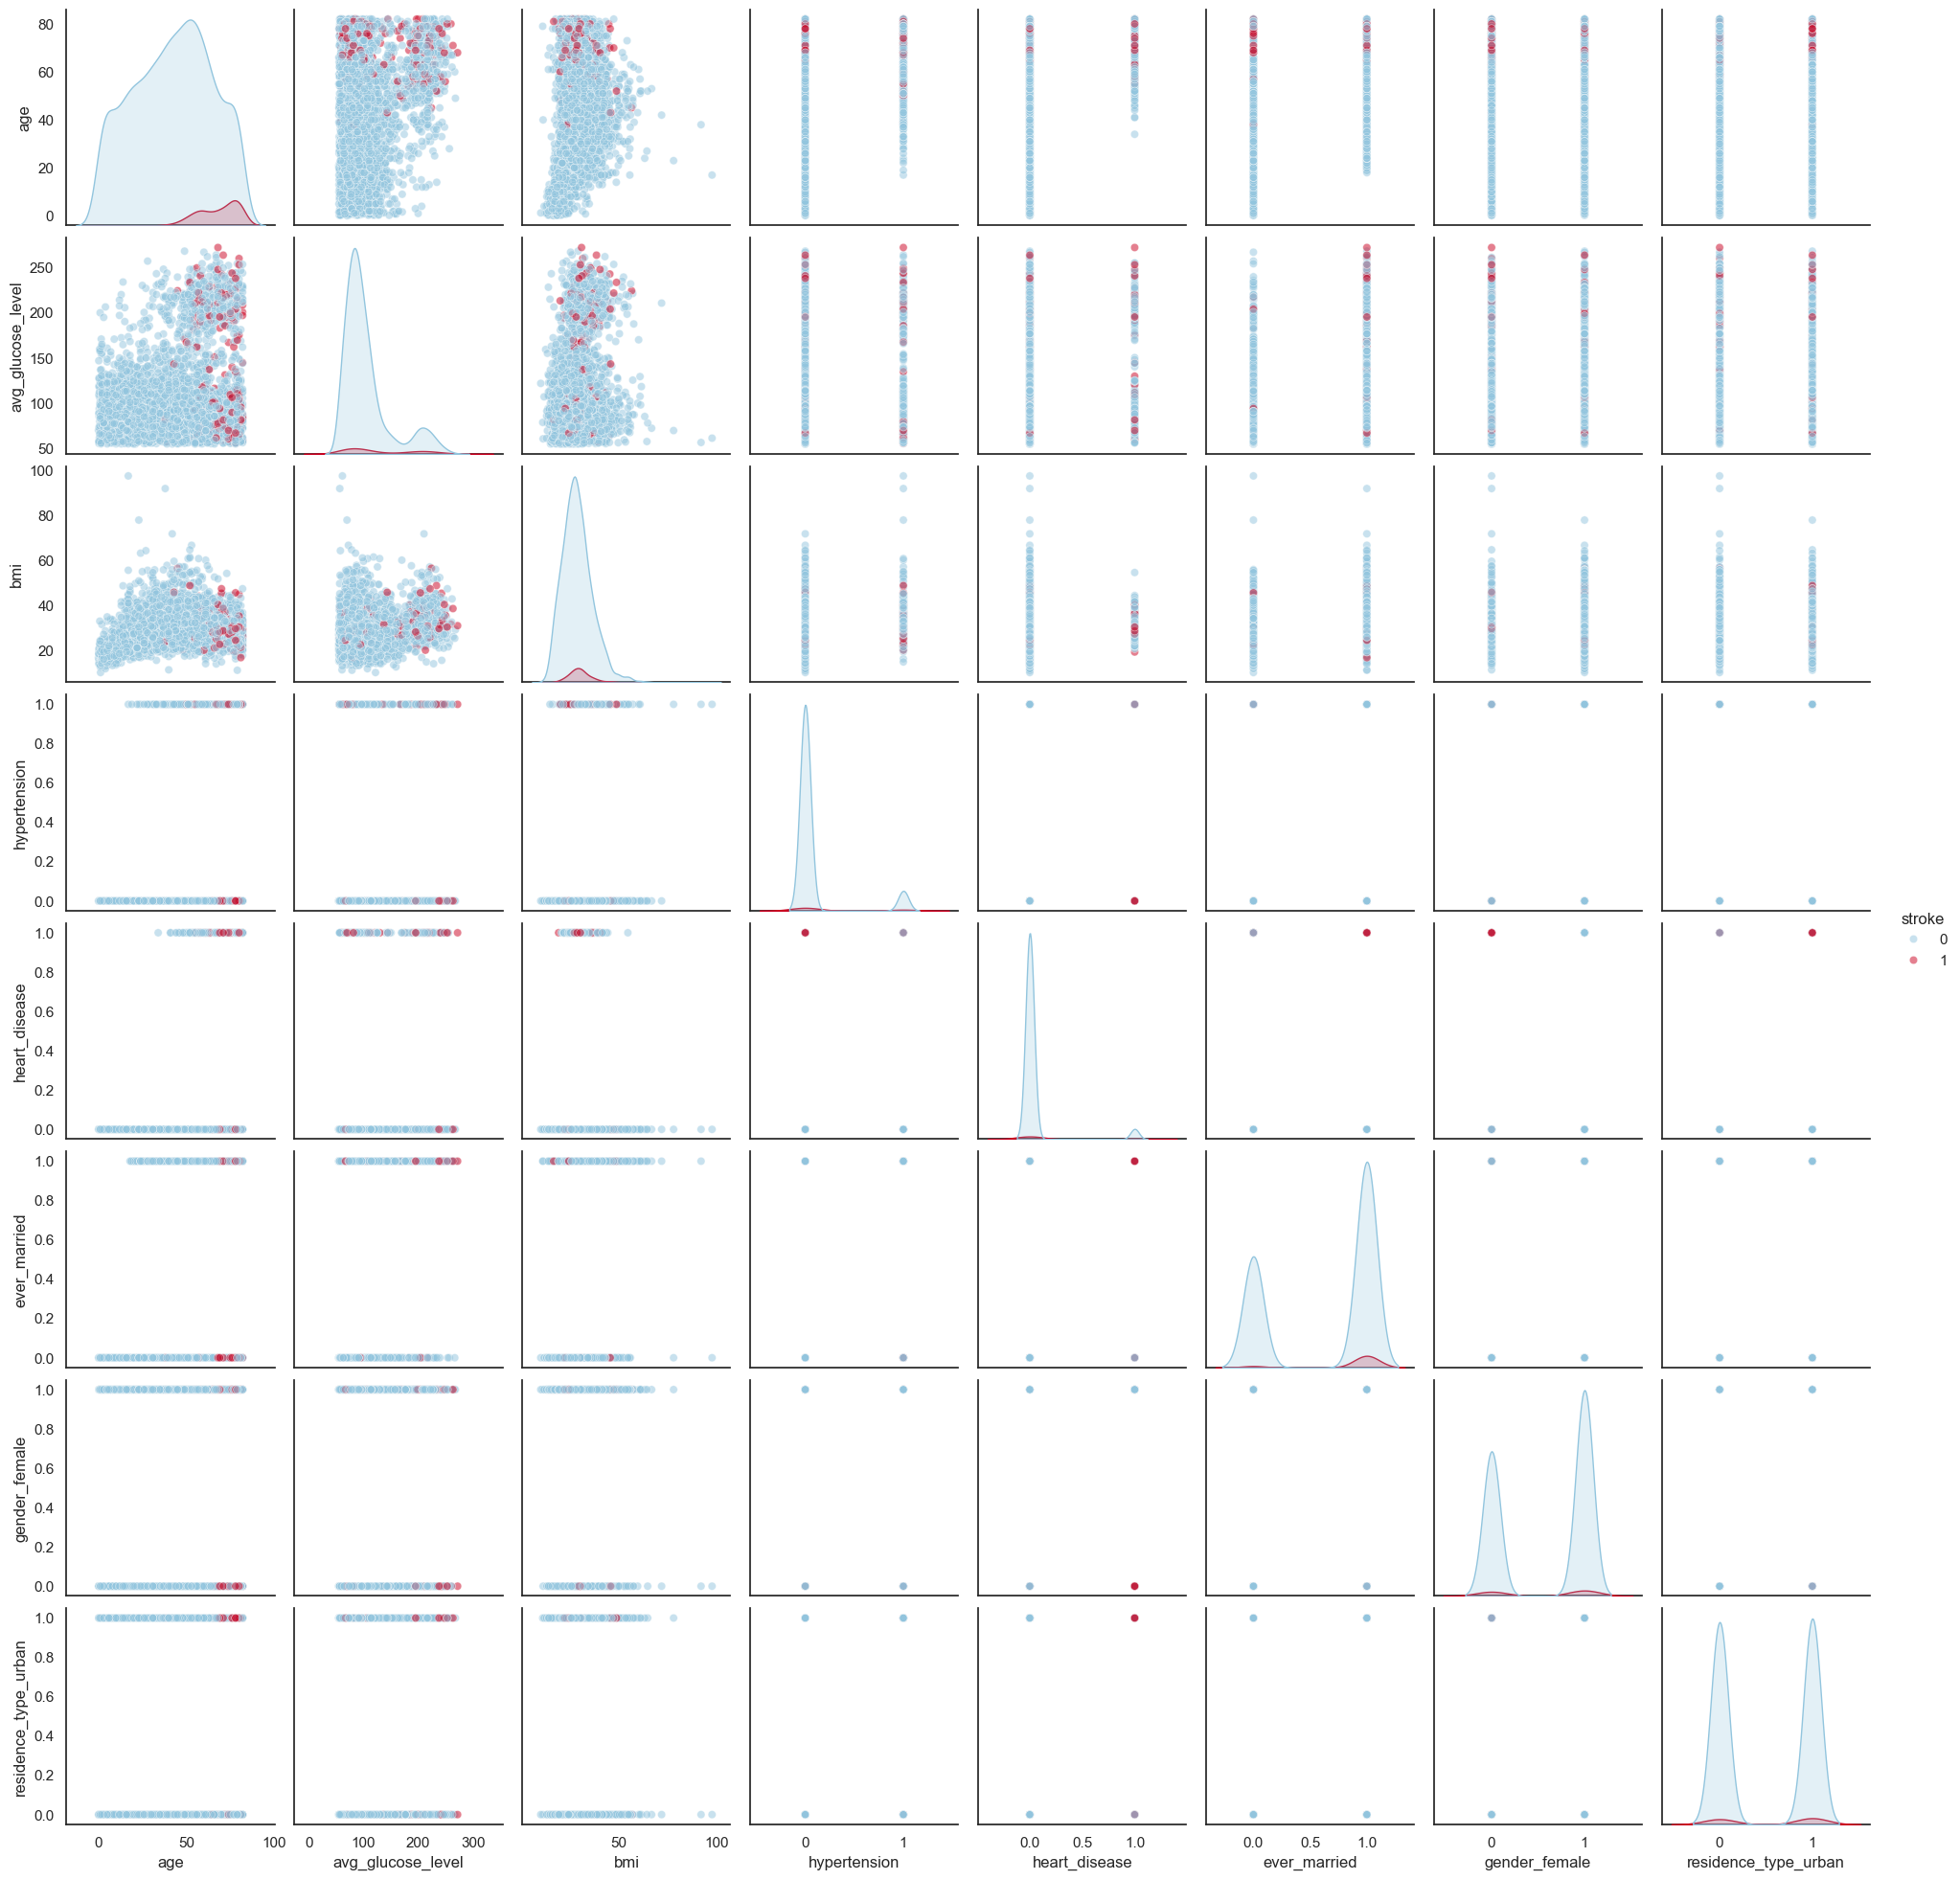

In [21]:
sns.pairplot(train_df[numeric+binary], hue="stroke", plot_kws={"alpha":0.5})
plt.show()

**Key observations:**
- age vs stroke:
    - Clear difference in distribution. Stroke patients (red dots) cluster at older ages. Age seems to be a strong predictor.

- avg_glucose_level vs stroke:
    - Stroke patients are concentrated in higher glucose levels (especially >150). A useful signal.

- bmi vs stroke:
    - Overlap is large, and red dots are spread. There's also less cases of stroke in more extreme BMI values. BMI is likely not a strong standalone indicator.

- hypertension vs stroke:
    - Stroke patients slightly more likely to have hypertension, but not strongly separable visually.

- ever_married vs stroke:
    - Stroke cases tend to be married. Consistent with age effect (older people are more likely married).

- gender vs stroke:
    - No clear difference. Gender seems not influential in this dataset as a standalone indicator.

- residence_type vs stroke:
    - No obvious impact of residence type on stroke.

### 2.11 Analyzing categorical predictors of `stroke`

In [22]:
pd.crosstab(train_df["smoking_status"], train_df["stroke"], normalize="index")

stroke,0,1
smoking_status,,
Unknown,0.969527,0.030473
formerly smoked,0.921459,0.078541
never smoked,0.952698,0.047302
smokes,0.945687,0.054313


- People who **formerly smoked** have the highest stroke rate (7.8%).
- Those who **currently smoke** are lower than expected (5.5%), likely due to age differences — they might be younger and not at high risk yet.
- “**Unknown**” is lowest (3.0%), possibly because it's missing at random or not filled for low-risk groups.

In [23]:
pd.crosstab(train_df["gender_female"], train_df["stroke"], normalize="index")

stroke,0,1
gender_female,,
0,0.948582,0.051418
1,0.953236,0.046764


- Stroke rate is slightly higher for **females** (5.1%) compared to **males** (4.6%).

In [24]:
pd.crosstab(train_df["work_type"], train_df["stroke"], normalize="index")

stroke,0,1
work_type,,
Govt_job,0.946360,0.053640
Never_worked,1.000000,0.000000
Private,0.950665,0.049335
Self-employed,0.917541,0.082459
children,0.998195,0.001805


- **Self-employed** group has the highest stroke rate (8.2%), as they might face different lifestyle/stress factors.
- **Never_worked** and **children** likely refer to people who are not in the workforce (e.g. young or elderly dependents), with the lowest stroke rate.
- **Govt_job** and **Private** have similar stroke rates (5.3% and 4.9% respectively).

In [25]:
pd.crosstab(train_df["residence_type_urban"], train_df["stroke"], 
            normalize="index")

stroke,0,1
residence_type_urban,,
0,0.954906,0.045094
1,0.947801,0.052199


- Relatively small difference in stroke rates — likely not an important predictor on its own.

In [26]:
pd.crosstab(train_df["hypertension"], train_df["stroke"], 
            normalize="index")

stroke,0,1
hypertension,,
0,0.960705,0.039295
1,0.863980,0.136020


- Massive difference — over 3x higher stroke rate **with hypertension**.
- This is one of the strongest **individual** predictors so far.

### 2.12 Summary of EDA

- **Data Quality**: The dataset is largely complete, with no duplicate entries. The primary issue were the missing values for the `bmi` feature, which were imputed using a simple Random Forest model. The `gender` feature had one "Other" entry, which will be handled by removal in the modeling pipeline.

- **Class Imbalance**: The target variable, `stroke`, is highly imbalanced, with approximately 5% of patients having experienced a stroke and 95% not. This imbalance will require careful consideration during model training and evaluation, with a focus on metrics sensitive to the minority class like the F2-score and PR-AUC.

- **Key Numerical Predictors**:
    - `age`: Shows a strong positive association with stroke. Stroke incidence becomes notably visible after 45 years and increases rapidly after 65.
    - `avg_glucose_level`: Patients who experienced a stroke tend to have significantly higher and more variable glucose levels. The distribution is right-skewed with many high-value outliers.
    - `bmi`: While stroke patients show a slightly higher median BMI, the distributions largely overlap with non-stroke patients. The feature is right-skewed with high-value outliers. Its direct correlation with stroke is weak.

- **Key Categorical/Binary Predictors**:
    - `hypertension`: A very strong indicator, with patients having hypertension showing a substantially higher proportion of strokes (over 3 times higher).
    - `heart_disease`: Similar to hypertension, having a heart disease significantly increases the proportion of stroke cases.
    - `ever_married`: Married individuals show a higher stroke rate, likely correlated with age.
    - `smoking_status`: "Formerly smoked" showed the highest stroke proportion, while "Unknown" had the lowest (might also be correlated with age).
    - `work_type`: "Self-employed" individuals had the highest stroke proportion, while "children" and "Never_worked" had the lowest, likely due to age associations.

- **Weaker Predictors**: `gender` and `Residence_type` did not show a strong or clear proportional difference in stroke incidence on their own.

- **Outliers & Skewness**: `avg_glucose_level` and `bmi` exhibit right-skewness and outliers. Log transformation for these will be applied during feature engineering to potentially normalize their distributions and reduce outlier influence for certain models.

## 3. Statistical inference

**Target population and sample**: The target population is patients at risk of stroke. The sample consists of 4,087 individuals with diverse demographic and health characteristics.

**Significance Level**: α = 0.05

**Hypotheses**:

1. **Age** and **stroke** risk:
- **H0 (Null Hypothesis)**: There is no significant difference in the **mean age** between **stroke** and **non-stroke** groups.
- **Ha (Alternative Hypothesis)**: There is a significant difference in the **mean age** between **stroke** and **non-stroke** groups.
- **Test**: Independent t-test.

2. **Average glucose level** and **stroke** risk:
- **H0 (Null Hypothesis)**: There is no significant difference in the **mean glucose level** between **stroke** and **non-stroke** groups.
- **Ha (Alternative Hypothesis)**: There is a significant difference in the **mean glucose level** between **stroke** and **non-stroke** groups.
- **Test**: Independent t-test.

3. **BMI** and **stroke** risk:
- **H0 (Null Hypothesis)**: There is no significant difference in the **mean BMI** between **stroke** and **non-stroke** groups.
- **Ha (Alternative Hypothesis)**: There is a significant difference in the **mean BMI** between **stroke** and **non-stroke** groups.
- **Test**: Independent t-test.

4. **Heart disease** and **stroke** risk:
- **H0 (Null Hypothesis)**: There is no significant association between **heart disease** and the risk of having a **stroke**.
- **Ha (Alternative Hypothesis)**: There is a significant association between **heart disease** and the risk of having a **stroke**.
- **Test**: Chi-Square test.

5. **Ever married** and **stroke** risk:
- **H0 (Null Hypothesis)**: There is no significant association between being **ever married** and the risk of having a **stroke**.
- **Ha (Alternative Hypothesis)**: There is a significant association between being **ever married** and the risk of having a **stroke**.
- **Test**: Chi-Square test.

6. **Gender** and **stroke** risk:
- **H0 (Null Hypothesis)**: There is no significant association between **gender** and the risk of having a **stroke**.
- **Ha (Alternative Hypothesis)**: There is a significant association between **gender** and the risk of having a **stroke**.
- **Test**: Chi-Square test.

**Independent t-test** assumptions:
- **Normality** (can be bypassed due to CLT with a large enough sample size)
- **Equal variances** (Welch's t-test can be used if variances differ)
- **Observation independence**

**Chi-square test** assumptions:
- **Observation independence**
- **Expected cell counts >= 5**
- **Cells in the contingency table are mutually exclusive**
- **Both variables are categorical**

### 3.1 Hypothesis 1: **Age** and **stroke** risk

In [27]:
check_normality(train_df, "age")
check_equal_variance(train_df, "age")

Normality (stroke=0): Statistic=0.970, p=0.000
Normality (stroke=1): Statistic=0.892, p=0.000
At least one group is NOT normally distributed.

Levene’s test for equal variance: Statistic=111.119, p=0.000
Variances are significantly different.


In [28]:
t_test(train_df, "age", equal_var=False)

T-test for 'age':
  t-statistic = -27.926
  p-value     = 0.000
  95% confidence interval for (non-stroke - stroke) mean difference: (-27.35, -23.75)

Means are significantly different.
Stroke group has higher age values.


With a low **p-value** we reject the null hypothesis - there is a **significant difference in mean age** between stroke and non-stroke groups (with a **95% CI** of 23.75 - 27.35 years). Mean **age** is higher in **stroke** groups.

### 3.2 Hypothesis 2: **Average glucose level** and **stroke** risk

In [29]:
check_normality(train_df, "avg_glucose_level")
check_equal_variance(train_df, "avg_glucose_level")

Normality (stroke=0): Statistic=0.805, p=0.000
Normality (stroke=1): Statistic=0.870, p=0.000
At least one group is NOT normally distributed.

Levene’s test for equal variance: Statistic=76.245, p=0.000
Variances are significantly different.


In [30]:
t_test(train_df, "avg_glucose_level", equal_var=False)

T-test for 'avg_glucose_level':
  t-statistic = -5.911
  p-value     = 0.000
  95% confidence interval for (non-stroke - stroke) mean difference: (-35.16, -17.57)

Means are significantly different.
Stroke group has higher avg_glucose_level values.


With a low **p-value** we reject the null hypothesis - there is a **significant difference in mean glucose level** between stroke and non-stroke groups (with a **95% CI** of 17.57 - 35.16 units). **Mean** glucose levels are higher in **stroke** groups.

### 3.3 Hypothesis 3: **BMI** and **stroke** risk

In [31]:
check_normality(train_df, "bmi")
check_equal_variance(train_df, "bmi")

Normality (stroke=0): Statistic=0.951, p=0.000
Normality (stroke=1): Statistic=0.954, p=0.000
At least one group is NOT normally distributed.

Levene’s test for equal variance: Statistic=17.651, p=0.000
Variances are significantly different.


In [32]:
t_test(train_df, "bmi", equal_var=False)

T-test for 'bmi':
  t-statistic = -3.327
  p-value     = 0.001
  95% confidence interval for (non-stroke - stroke) mean difference: (-2.34, -0.60)

Means are significantly different.
Stroke group has higher bmi values.


With a low **p-value** we reject the null hypothesis - there is a **significant difference in mean BMI** between stroke and non-stroke groups (with a **95% CI** of 0.60 - 2.34 units). Mean **BMI** is higher in **stroke** groups.

### 3.4 Hypothesis 4: **Heart disease** and **stroke** risk

In [33]:
chi_square_test(train_df, "heart_disease")

Contingency Table:


stroke,0,1
heart_disease,,
0,3703,163
1,185,36


Chi-square Test of Independence: Statistic=63.206, p=0.000
There is a significant association between heart_disease and stroke.

Proportion of stroke cases:
  0: 0.042 (95% CI: 0.036 - 0.048)
  1: 0.163 (95% CI: 0.114 - 0.212)

95% Confidence interval for difference in stroke rates (0 - 1): (-0.170, -0.072)
Higher proportion of strokes among 1.


With a low **p-value** we reject the null hypothesis - there is a **significant** association between **heart disease** and **stroke** (with a proportion difference of 0.072 - 0.17 with a **95% CI**). Higher proportion of strokes among people with a heart disease.

### 3.5 Hypothesis 5: **Ever married** and **stroke** risk

In [34]:
chi_square_test(train_df, "ever_married")

Contingency Table:


stroke,0,1
ever_married,,
0,1364,23
1,2524,176


Chi-square Test of Independence: Statistic=45.685, p=0.000
There is a significant association between ever_married and stroke.

Proportion of stroke cases:
  0: 0.017 (95% CI: 0.010 - 0.023)
  1: 0.065 (95% CI: 0.056 - 0.074)

95% Confidence interval for difference in stroke rates (0 - 1): (-0.060, -0.037)
Higher proportion of strokes among 1.


With a low **p-value** we reject the null hypothesis - there is a **significant** association between **ever being married** and **stroke** (with a proportion difference of 0.037 - 0.06 with a **95% CI**). Higher proportion of strokes among people that were ever married.

### 3.6 Hypothesis 6: **Gender** and **stroke** risk

In [35]:
chi_square_test(train_df, "gender_female")

Contingency Table:


stroke,0,1
gender_female,,
0,1605,87
1,2283,112


Chi-square Test of Independence: Statistic=0.369, p=0.544
No significant association between gender_female and stroke.

Proportion of stroke cases:
  0: 0.051 (95% CI: 0.041 - 0.062)
  1: 0.047 (95% CI: 0.038 - 0.055)

95% Confidence interval for difference in stroke rates (0 - 1): (-0.009, 0.018)
Direction is unclear (confidence interval crosses zero).


With a high **p-value** we fail reject the null hypothesis - there is **no significant** association between **gender** and **stroke** (**95% CI** in proportions overlaps 0).

## 3.7 Summary of Statistical Inference

- `Age` and `Stroke` Risk:
    - An independent t-test showed a highly significant difference in mean age between patients who had a stroke and those who did not (p < 0.001).
    - Patients who had a stroke were, on average, 23.75 to 27.35 years older (95% CI for mean difference) than those who did not. This confirms age as a critical factor.

- `Average Glucose Level` and `Stroke` Risk:
    - Similarly, an independent t-test indicated a significant difference in mean average glucose levels (p < 0.001).
    - Stroke patients had mean glucose levels that were 17.57 to 35.16 units higher (95% CI for mean difference) than non-stroke patients.

- `BMI` and `Stroke` Risk:
    - A significant difference was also found in mean BMI (p = 0.001).
    - Patients who experienced a stroke had mean BMIs that were 0.60 to 2.34 units higher (95% CI for mean difference) than those without a stroke.

- `Heart Disease` and `Stroke` Risk:
    - A Chi-Square test revealed a significant association between having heart disease and experiencing a stroke (p < 0.001).
    - The proportion of stroke cases was significantly higher among patients with heart disease (approx. 16.3%) compared to those without (approx. 4.2%). The difference in proportions is estimated to be between 7.2% and 17.0% (95% CI).

- `Marital Status (Ever Married)` and `Stroke` Risk:
    - A significant association was found between being ever married and stroke incidence (Chi-Square p < 0.001).
    - Individuals who had ever been married had a higher proportion of strokes (approx. 6.5%) compared to those never married (approx. 1.7%). The difference in proportions is estimated to be between 3.7% and 6.0% (95% CI).

- `Gender` and `Stroke` Risk:
    - The Chi-Square test showed no statistically significant association between gender (male vs. female) and stroke (p = 0.544). The confidence interval for the difference in proportions of stroke between males and females included zero.


**Overall Conclusion from Statistical Inference**:

The hypothesis tests confirm that older `age`, higher `average glucose levels`, higher `BMI`, a history of `heart disease`, and being `ever married` are statistically significant factors associated with an increased likelihood of stroke in this sample. `Gender` did not show a significant association. These findings reinforce the importance of these variables as potential predictors in the machine learning models.

## 4. Feature engineering and feature selection

### 4.1 Reloading the original X_train and X_test to ensure a clean slate for this phase, as train_df was modified during EDA.

In [36]:
df_original = pd.read_csv(DATA_PATH_NB).drop(columns=["id"])
df_original = df_original[df_original["gender"] != "Other"]

X = df_original.drop(columns=["stroke"])
y = df_original["stroke"]

X_train_val_raw, X_test_raw, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_val_raw, y_train_val, 
    test_size=0.25, random_state=42, stratify=y_train_val
)

print("Original data shape:", X.shape)
print("X_train_raw/y_train shape:", X_train_raw.shape, y_train.shape)
print("X_val_raw/y_val shape:", X_val_raw.shape, y_val.shape)
print("X_test_raw/y_test shape:", X_test_raw.shape, y_test.shape)

print("\nStratification check:")
print("\ny_train distribution:\n", y_train.value_counts(normalize=True) * 100)
print("\ny_val distribution:\n", y_val.value_counts(normalize=True) * 100)
print("\ny_test distribution:\n", y_test.value_counts(normalize=True) * 100)

Original data shape: (5109, 10)
X_train_raw/y_train shape: (3065, 10) (3065,)
X_val_raw/y_val shape: (1022, 10) (1022,)
X_test_raw/y_test shape: (1022, 10) (1022,)

Stratification check:

y_train distribution:
 stroke
0    95.138662
1     4.861338
Name: proportion, dtype: float64

y_val distribution:
 stroke
0    95.107632
1     4.892368
Name: proportion, dtype: float64

y_test distribution:
 stroke
0    95.107632
1     4.892368
Name: proportion, dtype: float64


The train data was further split into train and validation data for model evaluation.

### 4.2 Imputing the missing BMI in all 3 splits

In [37]:
X_train_imputed = impute_bmi_with_pipeline(X_train_raw)
X_val_imputed = impute_bmi_with_pipeline(X_val_raw)
X_test_imputed = impute_bmi_with_pipeline(X_test_raw)

print("Missing BMI in X_train_raw before imputation:", 
      X_train_raw['bmi'].isna().sum())
print("Missing BMI in X_val_raw before imputation:", 
      X_val_raw['bmi'].isna().sum())
print("Missing BMI in X_test_raw before imputation:", 
      X_test_raw['bmi'].isna().sum())

print("\nMissing BMI in X_train_imputed after imputation:", 
      X_train_imputed['bmi'].isna().sum())
print("Missing BMI in X_val_imputed after imputation:", 
      X_val_imputed['bmi'].isna().sum())
print("Missing BMI in X_test_imputed after imputation:", 
      X_test_imputed['bmi'].isna().sum())

X_train_imputed.head()

Missing BMI in X_train_raw before imputation: 130
Missing BMI in X_val_raw before imputation: 33
Missing BMI in X_test_raw before imputation: 38

Missing BMI in X_train_imputed after imputation: 0
Missing BMI in X_val_imputed after imputation: 0
Missing BMI in X_test_imputed after imputation: 0


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
1666,Female,3.0,0,0,No,children,Urban,57.33,16.8,Unknown
933,Female,74.0,0,0,Yes,Self-employed,Urban,99.21,22.1,never smoked
1797,Female,26.0,0,0,No,Private,Urban,168.15,22.9,never smoked
2774,Female,50.0,0,0,Yes,Private,Rural,82.10,26.4,Unknown
1459,Female,49.0,0,0,Yes,Govt_job,Rural,83.84,19.3,formerly smoked


### 4.3 Creating new features

- New features were created or modified based on current information:

    - log-scaled `avg_glucose_level`
    - log-scaled `bmi`
    - `bmi` categories: underweight (<18.5), normal (<24.9), overweight (<29.9), obese (>30)
    - `age` groups: child (<18), adult (<40), middle aged (<60), senior (>60)
    - `glucose level` categories: normal glucose (<100), prediabetes glucose (<125), diabetes glucose (>125)
    - `hypertension_and_smokes` interaction
    - `age_X_heart_disease` interaction

In [38]:
X_train_eng = create_new_features(X_train_imputed)
X_val_eng = create_new_features(X_val_imputed)
X_test_eng = create_new_features(X_test_imputed)

X_train_eng.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,avg_glucose_level_log,bmi_log,bmi_category,age_group,glucose_level_category,hypertension_and_smokes,age_X_heart_disease
1666,Female,3.0,0,0,No,children,Urban,57.33,16.8,Unknown,4.066117,2.879198,Underweight,Child,Normal_glucose,0,0.0
933,Female,74.0,0,0,Yes,Self-employed,Urban,99.21,22.1,never smoked,4.607268,3.139833,Normal,Senior,Normal_glucose,0,0.0
1797,Female,26.0,0,0,No,Private,Urban,168.15,22.9,never smoked,5.130786,3.173878,Normal,Adult,Diabetes_glucose,0,0.0
2774,Female,50.0,0,0,Yes,Private,Rural,82.10,26.4,Unknown,4.420045,3.310543,Overweight,Middle_Aged,Normal_glucose,0,0.0
1459,Female,49.0,0,0,Yes,Govt_job,Rural,83.84,19.3,formerly smoked,4.440767,3.010621,Normal,Middle_Aged,Normal_glucose,0,0.0


### 4.4 Feature preprocessing

Defining numerical features (for scaling), binary features (for passthrough), categorical features (for one-hot-encoding). Also removing `bmi` and `avg_glucose_level` and using their `log` versions instead.

In [39]:
numerical_features_scale = ['age', 'avg_glucose_level_log', 
                            'bmi_log', 'age_X_heart_disease']
binary_features = ['hypertension', 'heart_disease', 'hypertension_and_smokes']
categorical_features_ohe = ['gender', 'ever_married', 'work_type', 
                            'Residence_type', 'smoking_status', 'bmi_category', 
                            'age_group', 'glucose_level_category']

In [40]:
main_preprocessor = ColumnTransformer(
    transformers=[
        ('num_scale', StandardScaler(), numerical_features_scale),
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore', 
                                  drop='first', sparse_output=False), 
                                  categorical_features_ohe),
        ('num_passthrough', 'passthrough', binary_features)
    ],
    remainder='drop'
)

In [41]:
X_train_processed_np = main_preprocessor.fit_transform(X_train_eng)
X_val_processed_np = main_preprocessor.transform(X_val_eng)
X_test_processed_np = main_preprocessor.transform(X_test_eng)

feature_names_out = main_preprocessor.get_feature_names_out()
X_train_processed = pd.DataFrame(X_train_processed_np, 
                                 columns=feature_names_out, 
                                 index=X_train_eng.index)
X_val_processed = pd.DataFrame(X_val_processed_np, 
                               columns=feature_names_out, 
                               index=X_val_eng.index)
X_test_processed = pd.DataFrame(X_test_processed_np, 
                                columns=feature_names_out, 
                                index=X_test_eng.index)

In [42]:
print("\nShape of X_train_processed:", X_train_processed.shape)
print("Shape of X_val_processed:", X_val_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)
X_train_processed.head()


Shape of X_train_processed: (3065, 25)
Shape of X_val_processed: (1022, 25)
Shape of X_test_processed: (1022, 25)


,num_scale__age,num_scale__avg_glucose_level_log,num_scale__bmi_log,num_scale__age_X_heart_disease,cat_ohe__gender_Male,cat_ohe__ever_married_Yes,cat_ohe__work_type_Never_worked,cat_ohe__work_type_Private,cat_ohe__work_type_Self-employed,cat_ohe__work_type_children,...,cat_ohe__bmi_category_Overweight,cat_ohe__bmi_category_Underweight,cat_ohe__age_group_Child,cat_ohe__age_group_Middle_Aged,cat_ohe__age_group_Senior,cat_ohe__glucose_level_category_Normal_glucose,cat_ohe__glucose_level_category_Prediabetes_glucose,num_passthrough__hypertension,num_passthrough__heart_disease,num_passthrough__hypertension_and_smokes
1666,-1.775941,-1.513597,-1.917321,-0.24503,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
933,1.358168,0.008201,-0.895999,-0.24503,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1797,-0.760666,1.480411,-0.762586,-0.24503,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2774,0.298751,-0.518299,-0.227052,-0.24503,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1459,0.254609,-0.460024,-1.402328,-0.24503,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


### 4.5 Feature selection

Checking feature importance using permutation:


Permutation Importances (on validation set, using RandomForest):
num_scale__age                                         0.050083
cat_ohe__age_group_Senior                              0.013990
cat_ohe__ever_married_Yes                              0.004182
cat_ohe__smoking_status_formerly smoked                0.003820
cat_ohe__work_type_Self-employed                       0.003344
cat_ohe__glucose_level_category_Normal_glucose         0.003105
cat_ohe__smoking_status_never smoked                   0.001983
num_scale__age_X_heart_disease                         0.001697
cat_ohe__bmi_category_Underweight                      0.001471
cat_ohe__smoking_status_smokes                         0.000563
cat_ohe__age_group_Child                               0.000189
cat_ohe__glucose_level_category_Prediabetes_glucose    0.000084
cat_ohe__work_type_Never_worked                       -0.000001
num_passthrough__heart_disease                        -0.000243
cat_ohe__work_type_children           

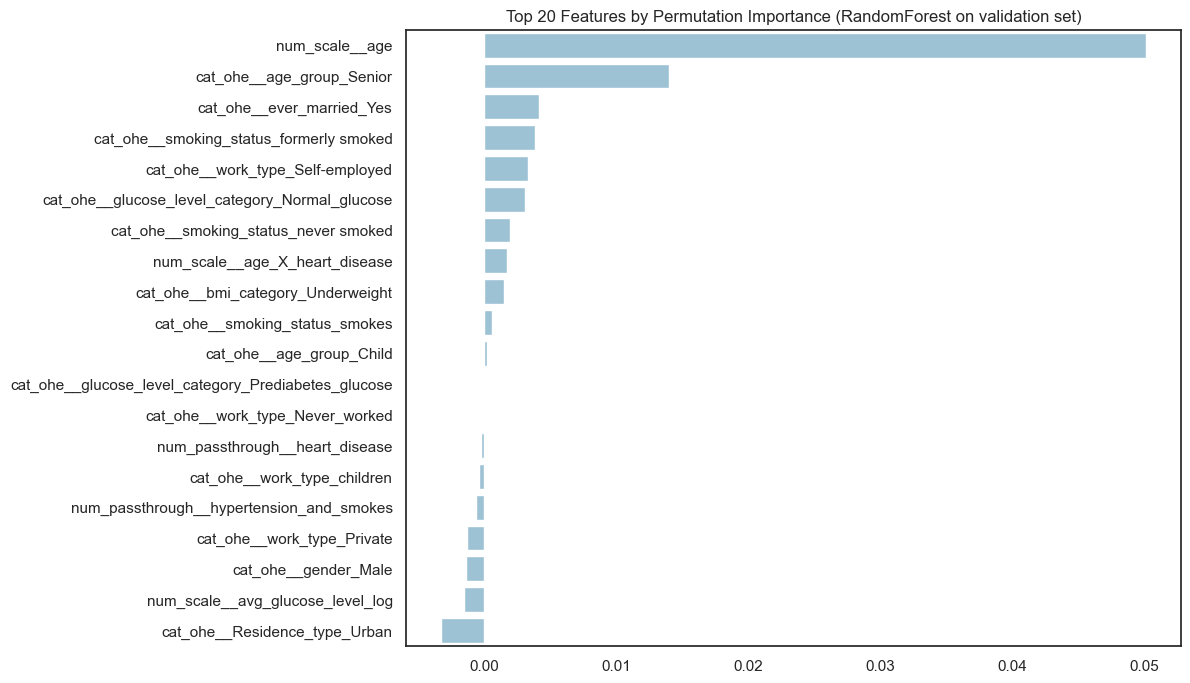

In [43]:
feature_importance_permutation(X_train_processed, y_train, 
                               X_val_processed, y_val)

It seems like `Residence_type` (specifically its one-hot encoded form like `cat_ohe__Residence_type_Urban`), `avg_glucose_level_log` and `cat_ohe__gender_Male` columns are negatively impacting the model (shuffling the values of these features on average led to a slight increase in the model's performance, suggesting they might introduce more noise than signal). `work_type` one-hot encoded features also appear to be somewhat negative, but the `cat_ohe__work_type_Self-employed` feature is providing good signal.

Recursive feature elimination:

In [44]:
feature_importance_rfe(X_train_processed, y_train)


Selected features by RFE (Logistic Regression):
Index(['num_scale__age', 'num_scale__bmi_log',
       'num_scale__age_X_heart_disease', 'cat_ohe__work_type_Self-employed',
       'cat_ohe__work_type_children', 'cat_ohe__smoking_status_smokes',
       'cat_ohe__bmi_category_Obese', 'cat_ohe__bmi_category_Overweight',
       'cat_ohe__bmi_category_Underweight', 'cat_ohe__age_group_Child',
       'cat_ohe__age_group_Middle_Aged',
       'cat_ohe__glucose_level_category_Normal_glucose',
       'num_passthrough__hypertension', 'num_passthrough__heart_disease',
       'num_passthrough__hypertension_and_smokes'],
      dtype='object')


Here it seems that the `work_type` one-hot encoded features once again have important signal, so they will be kept. Therefore, in the final sets, `Residence_type`, `avg_glucose_level` and `gender` (and their one-hot encoded versions) will be dropped.

In [45]:
numerical_features_scale_final = ['age', 'bmi_log', 'age_X_heart_disease']
binary_features_final = ['hypertension', 'heart_disease', 
                         'hypertension_and_smokes']
categorical_features_ohe_final = ['ever_married', 'work_type', 
                                  'smoking_status', 'bmi_category', 
                                  'age_group', 'glucose_level_category']

main_preprocessor_final = ColumnTransformer(
    transformers=[
        ('num_scale', StandardScaler(), numerical_features_scale_final),
        ('cat_ohe', OneHotEncoder(handle_unknown='ignore', drop='first',
                                   sparse_output=False),
                                     categorical_features_ohe_final),
        ('num_passthrough', 'passthrough', binary_features_final)
    ],
    remainder='drop'
)

In [46]:
X_train_final_np = main_preprocessor_final.fit_transform(X_train_eng)
X_val_final_np = main_preprocessor_final.transform(X_val_eng)
X_test_final_np = main_preprocessor_final.transform(X_test_eng)

feature_names_out_final = main_preprocessor_final.get_feature_names_out()
X_train_final = pd.DataFrame(X_train_final_np, columns=feature_names_out_final,
                              index=X_train_eng.index)
X_val_final = pd.DataFrame(X_val_final_np, columns=feature_names_out_final,
                            index=X_val_eng.index)
X_test_final = pd.DataFrame(X_test_final_np, columns=feature_names_out_final,
                             index=X_test_eng.index)

In [47]:
print("Final training data shape:", X_train_final.shape)
print("Final validation data shape:", X_val_final.shape)
print("Final test data shape:", X_test_final.shape)

Final training data shape: (3065, 22)
Final validation data shape: (1022, 22)
Final test data shape: (1022, 22)


Saving the final preprocessor to a .pkl file for final model deployment.

In [48]:
final_preprocessor_path = os.path.join(ARTIFACTS_DIR_NB, 'final_preprocessor.pkl')
with open(final_preprocessor_path, 'wb') as f_pre:
    pickle.dump(main_preprocessor_final, f_pre)
print("Final data preprocessor (main_preprocessor_final) "
      f"saved to {final_preprocessor_path}")

Final data preprocessor (main_preprocessor_final) saved to c:\Users\IT\Desktop\M3S2 task\artifacts\final_preprocessor.pkl


### 4.6 Summary for feature engineering and feature selection

- **Data Preparation for Modeling**:
    - The dataset was split into training (60%), validation (20%), and test (20%) sets, ensuring stratification by the stroke outcome. This provides dedicated sets for model training, hyperparameter tuning/feature selection, and final unbiased evaluation.
    - Missing bmi values in all three data splits were imputed using a pre-trained Random Forest pipeline (itself trained only on data from the initial 60% training partition to prevent leakage).

- **Feature Engineering**:
    - Several new features were created from the existing raw data (after BMI imputation) to capture more information:
        - Log Transformations: `avg_glucose_level` and `bmi` were log-transformed to create `avg_glucose_level_log` and `bmi_log`. This was done to address the right-skewness and outlier sensitivity observed during EDA for these variables.
        - Categorical Bins:
            - `bmi_category`: Created from original `bmi` into "Underweight", "Normal", "Overweight", "Obese".
            - `age_group`: Created from `age` into "Child", "Adult", "Middle_Aged", "Senior".
            - `glucose_level_category`: Created from original `avg_glucose_level` into "Normal_glucose", "Prediabetes_glucose", "Diabetes_glucose".
        - Interaction Terms:
            - `hypertension_and_smokes`: A binary indicator for patients who have `hypertension` AND `currently smoke`.
            - `age_X_heart_disease`: The product of `age` and the `heart disease` binary indicator.

- **Initial Preprocessing for Feature Selection**:
    - The engineered dataset (X_train_eng, X_val_eng, X_test_eng), which included both original and new features, was then processed by an initial ColumnTransformer (main_preprocessor).
    - This involved scaling numerical features (including the new _log versions and numerical interactions), one-hot encoding all categorical features (original and engineered bins), and passing through original binary features. This resulted in a set of 25 processed features.

- **Feature Selection Analysis**:
    - Permutation Importance: Calculated using a RandomForestClassifier on the validation set. This highlighted `num_scale__age`, `cat_ohe__age_group_Senior`, and several other engineered categories and interactions as important. Notably, `num_scale__avg_glucose_level_log`, `cat_ohe__gender_Male`, and `cat_ohe__Residence_type_Urban` showed negative importance, suggesting they might be detrimental for this specific model and metric.
    - Recursive Feature Elimination (RFE): Conducted with Logistic Regression, RFE selected a set of 15 features, which notably included `num_scale__bmi_log` and several one-hot encoded categories from `work_type`, `bmi_category`, and `age_group`, as well as `num_passthrough__hypertension`.

- **Final Feature Set Determination**:
    - Based on the insights from permutation importance and RFE, a final set of features was chosen.
    - Dropped Features:
        - Original `gender` (and its OHE version `cat_ohe__gender_Male`).
        - Original `Residence_type` (and its OHE version `cat_ohe__Residence_type_Urban`).
        - The continuous `avg_glucose_level_log` (relying instead on `glucose_level_category`).
        - The original (non-log-transformed) continuous `bmi` and `avg_glucose_level` were also effectively dropped as their transformed/categorical versions were selected.
    - Kept Features: The remaining original and engineered features, including `age`, `bmi_log` (due to RFE), interactions, and categorical bins.
    - A final preprocessor (main_preprocessor_final) was defined to transform the engineered data into this selected feature set, resulting in 22 features for model training (X_train_final, X_val_final, X_test_final).

## 5. Model Selection and Evaluation

Making the primary metric F2 (F-beta) scorer:

In [49]:
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, zero_division=0)

### 5.1 Defining baseline predictors

--- Dummy Classifier (Stratified) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.95      0.96      0.96       972
      Stroke       0.10      0.08      0.09        50

    accuracy                           0.92      1022
   macro avg       0.52      0.52      0.52      1022
weighted avg       0.91      0.92      0.91      1022

F2 Score: 0.0826
PR-AUC: 0.0526
ROC-AUC: 0.5205


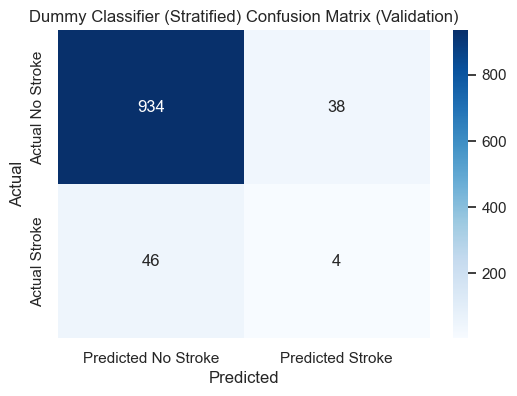

In [50]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)
dummy_clf.fit(X_train_final, y_train)
y_val_pred_dummy = dummy_clf.predict(X_val_final)
y_val_pred_dummy_proba = dummy_clf.predict_proba(X_val_final)[:,1]

dummy_scores = evaluate_model_performance(y_val, y_val_pred_dummy,
                                        y_val_pred_dummy_proba,
                                        model_name="Dummy Classifier (Stratified)")

The **Dummy Classifier (stratified)** provides a very basic baseline. Its **F2-score of 0.0826** and **PR-AUC of 0.0526** represent the performance expected by random guessing according to class distribution. Further models must significantly outperform these metrics. The **recall** for stroke is **0.08** and **precision** is **0.10**.

--- Simple Rule-Based (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.97      0.90      0.93       972
      Stroke       0.18      0.42      0.25        50

    accuracy                           0.88      1022
   macro avg       0.57      0.66      0.59      1022
weighted avg       0.93      0.88      0.90      1022

F2 Score: 0.3292
PR-AUC: 0.1025
ROC-AUC: 0.6596


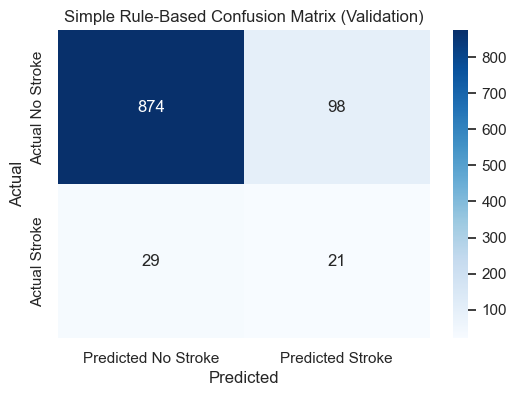

In [51]:
y_val_pred_simple_rules = simple_rule_predictor(X_val_raw)

simple_rules_scores = evaluate_model_performance(y_val, y_val_pred_simple_rules,
                                                  y_val_pred_simple_rules,
                                                 model_name="Simple Rule-Based")

The **simple rule-based predictor**, relying on key risk factors like age and hypertension, achieves an **F2-score of 0.3292** and a **PR-AUC of 0.1025**. It correctly identified 21 stroke cases while misclassifying 98 non-stroke patients as having stroke. This provides a more 'common-sense' baseline than the dummy classifier. The **recall** for stroke is **0.42** and **precision** is **0.18**. This simple predictor performs way better than the stratified dummy classifier.

Checking Variance Inflation Factor for Logistic Regression baseline model

In [52]:
check_vif(X_train_final)

                                                Feature    VIF
2                        num_scale__age_X_heart_disease  40.92
20                       num_passthrough__heart_disease  40.13
0                                        num_scale__age  16.10
16                            cat_ohe__age_group_Senior  11.22
7                           cat_ohe__work_type_children   6.94
14                             cat_ohe__age_group_Child   6.30
11                          cat_ohe__bmi_category_Obese   6.23
1                                    num_scale__bmi_log   5.73
15                       cat_ohe__age_group_Middle_Aged   4.28
12                     cat_ohe__bmi_category_Overweight   2.46
5                            cat_ohe__work_type_Private   2.41
3                             cat_ohe__ever_married_Yes   2.24
6                      cat_ohe__work_type_Self-employed   1.99
9                  cat_ohe__smoking_status_never smoked   1.83
13                    cat_ohe__bmi_category_Underweight

After continuous iterations of removing the highest VIF value features one by one until none pass the treshold of 5 or above, the final feature set is obtained for the LR model.

In [53]:
cols_to_drop = ['num_scale__age_X_heart_disease', 'num_scale__age', 
                'cat_ohe__work_type_children', 'cat_ohe__work_type_children', 
                'cat_ohe__bmi_category_Obese']

X_train_for_lr = X_train_final.drop(columns=cols_to_drop)
X_val_for_lr = X_val_final.drop(columns=cols_to_drop)
check_vif(X_train_for_lr)

                                                Feature   VIF
10                             cat_ohe__age_group_Child  2.93
12                            cat_ohe__age_group_Senior  2.15
1                             cat_ohe__ever_married_Yes  2.11
3                            cat_ohe__work_type_Private  2.03
11                       cat_ohe__age_group_Middle_Aged  1.90
4                      cat_ohe__work_type_Self-employed  1.82
6                  cat_ohe__smoking_status_never smoked  1.77
0                                    num_scale__bmi_log  1.76
13       cat_ohe__glucose_level_category_Normal_glucose  1.75
14  cat_ohe__glucose_level_category_Prediabetes_glucose  1.73
7                        cat_ohe__smoking_status_smokes  1.66
9                     cat_ohe__bmi_category_Underweight  1.60
5               cat_ohe__smoking_status_formerly smoked  1.59
17             num_passthrough__hypertension_and_smokes  1.39
15                        num_passthrough__hypertension  1.36
16      

--- Logistic Regression (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.68      0.81       972
      Stroke       0.13      0.90      0.22        50

    accuracy                           0.69      1022
   macro avg       0.56      0.79      0.51      1022
weighted avg       0.95      0.69      0.78      1022

F2 Score: 0.4032
PR-AUC: 0.1630
ROC-AUC: 0.8227


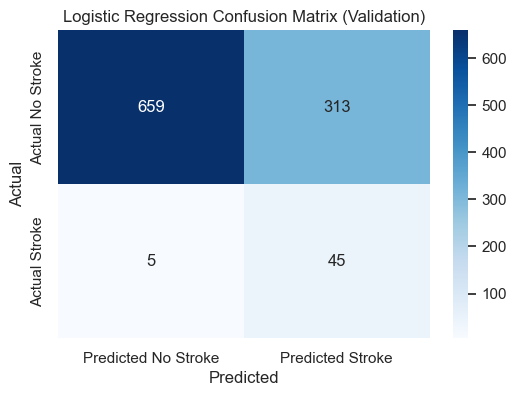

In [54]:
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', 
                             random_state=42, max_iter=1000)
log_reg.fit(X_train_for_lr, y_train)

y_val_pred_log_reg = log_reg.predict(X_val_for_lr)
y_val_pred_log_reg_proba = log_reg.predict_proba(X_val_for_lr)[:, 1]

log_reg_scores = evaluate_model_performance(y_val, y_val_pred_log_reg, 
                                            y_val_pred_log_reg_proba, 
                                            model_name="Logistic Regression")

The **Logistic Regression** baseline, with balanced class weights, achieves an **F2-score of 0.4032** and a **PR-AUC of 0.1630**. It shows a strong **recall** of **0.90** for stroke cases, indicating its ability to identify many true positives, but at the cost of a lower **precision** of **0.13**. The **ROC-AUC of 0.8227** suggests good overall discriminative power. This model significantly outperforms the dummy and rule-based baselines in terms of F2-score, PR-AUC and ROC-AUC.

So far, three methods of baseline performance were established for the stroke prediction on the validation set:

- **Dummy Classifier (stratified)**: Achieved an **F2-score of 0.0826**, **PR-AUC of 0.0526**, and **ROC-AUC of 0.5205**. This represents the performance expected by chance, adjusted for class distribution.

- **Simple rule-based predictor**: Based on key risk factors, this model had an **F2-score of 0.3292**, a **PR-AUC of 0.1025**, and an **ROC-AUC of 0.6596**. This shows that simple rules can already achieve a good balance towards high recall for this problem. It correctly identified 21 out of 50 stroke cases with a **recall of 0.42**, and a precision of **0.18**.

- **Logistic Regression**: The first machine learning baseline achieved an **F2-score of 0.4032**. This is the highest F2-score so far. The Logistic Regression demonstrated superior overall power with a **PR-AUC of 0.1630** and a **ROC-AUC of 0.8277**. Its **recall** for stroke cases was high at **0.90**, but this came with a precision of **0.13**.

Conclusion from Baselines:

- The rule-based model provides a surprisingly strong F2-score baseline.
- The Logistic Regression model, while having a slightly lower F2-score, shows better underlying potential for distinguishing classes (higher PR-AUC and ROC-AUC). This suggests that with proper threshold tuning, the Logistic Regression model could potentially achieve a higher F2-score. The further, advanced models need to achieve a higher F2-score than the simple rules. The Logistic Regression showed it can separate stroke and non-stroke patients well (good AUCs), so the goal is to build on that and get a great F2-score by picking the right settings and decision threshold.

### 5.2 Training, tuning, evaluating models

Creating weight for XGBoost/LightGBM models for class balancing:

In [55]:
counts_train = y_train.value_counts()
scale_pos_weight_value = counts_train[0] / counts_train[1]
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

Calculated scale_pos_weight: 19.57


--- RandomForest ---
Starting RandomForest GridSearchCV (5-fold CV)
Fitting 5 folds for each of 108 candidates, totalling 540 fits
GridSearchCV for RandomForest completed in 37.77 seconds.
Best RandomForest params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Best score (F2 score) from CV: 0.3298

--- Tuned RandomForest (default thresh) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.97      0.89      0.93       972
      Stroke       0.16      0.42      0.24        50

    accuracy                           0.87      1022
   macro avg       0.57      0.65      0.58      1022
weighted avg       0.93      0.87      0.89      1022

F2 Score: 0.3201
PR-AUC: 0.1534
ROC-AUC: 0.8250


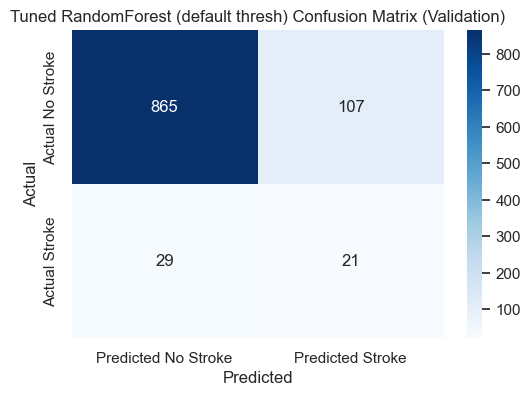

--- RandomForest: Optimizing threshold for F2 on validation set ---
Optimal threshold for RandomForest on validation: 0.34
Max F2-score at this threshold on validation: 0.4008


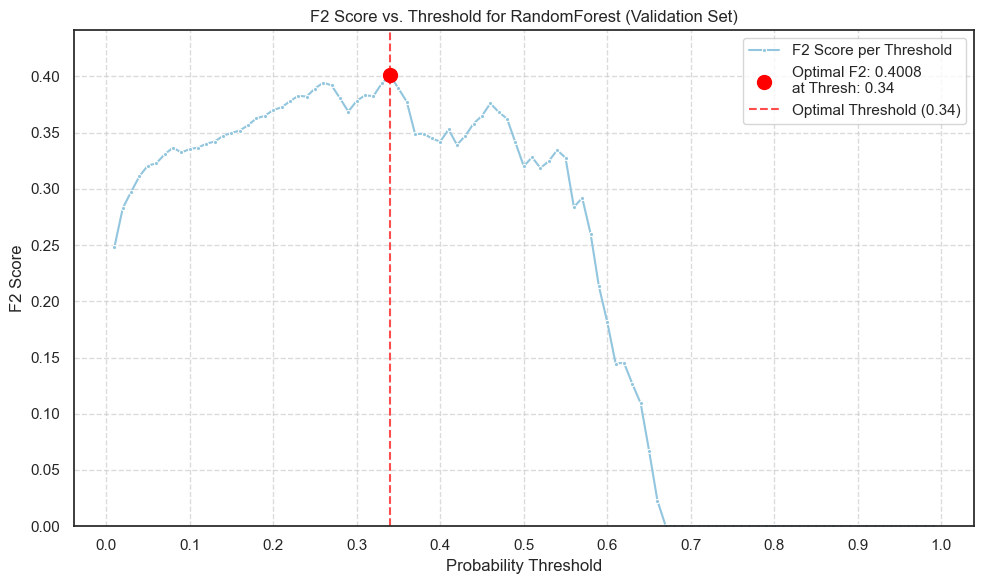

--- Tuned RandomForest (Optimal Thresh F2=0.4008) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.73      0.84       972
      Stroke       0.13      0.80      0.23        50

    accuracy                           0.74      1022
   macro avg       0.56      0.77      0.54      1022
weighted avg       0.94      0.74      0.81      1022

F2 Score: 0.4008
PR-AUC: 0.1534
ROC-AUC: 0.8250


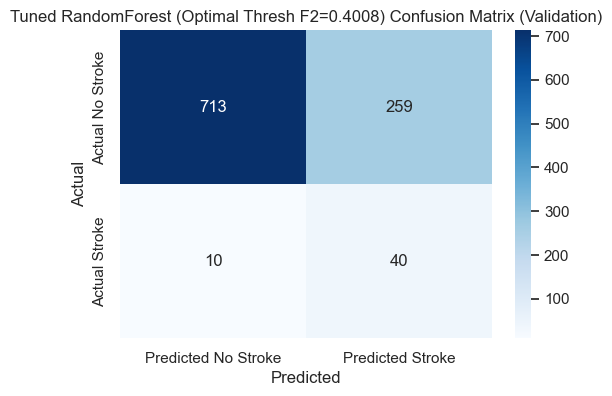

In [56]:
model_results_summary = []

rf_model_base = RandomForestClassifier(random_state=42, 
                                       class_weight='balanced', n_jobs=-1)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_rf, rf_run_scores = train_tune_evaluate_model(
    rf_model_base, rf_param_grid,
    X_train_final, y_train,
    X_val_final, y_val,
    scorer=f2_scorer,
    model_name_str="RandomForest"
)

model_results_summary.append(rf_run_scores)

The **Random Forest**, when its threshold is optimized for F2, now achieves an **F2-score of 0.4008**. This is a significant improvement over its default threshold performance and is now very close to the **Logistic Regression** baseline's F2 (at default threshold). The Gradient Boosted Tree models will be interesting to compare, as they might offer better performance.

--- XGBoost ---
Starting XGBoost GridSearchCV (5-fold CV)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearchCV for XGBoost completed in 4.94 seconds.
Best XGBoost params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Best score (F2 score) from CV: 0.3825

--- Tuned XGBoost (default thresh) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.72      0.83       972
      Stroke       0.13      0.80      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.76      0.53      1022
weighted avg       0.94      0.72      0.80      1022

F2 Score: 0.3899
PR-AUC: 0.1461
ROC-AUC: 0.8197


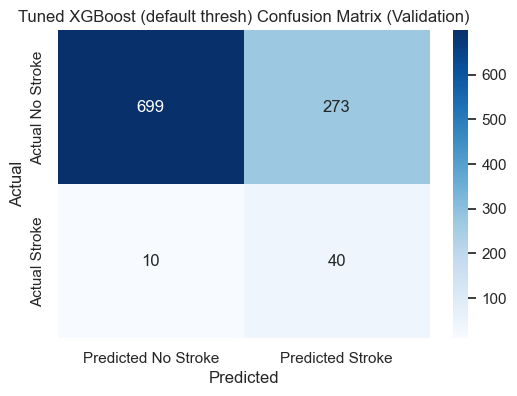

--- XGBoost: Optimizing threshold for F2 on validation set ---
Optimal threshold for XGBoost on validation: 0.49
Max F2-score at this threshold on validation: 0.3958


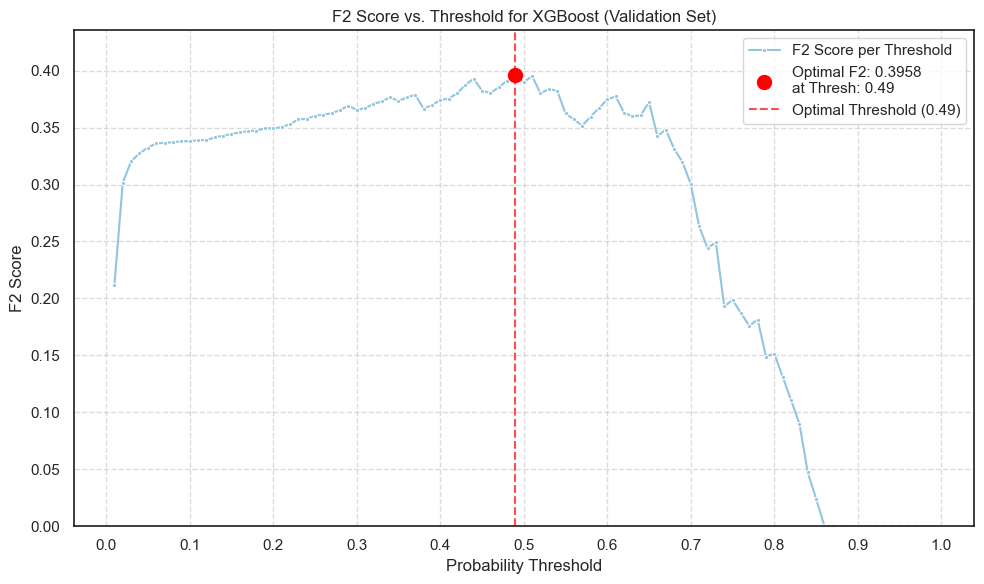

--- Tuned XGBoost (Optimal Thresh F2=0.3958) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.72      0.83       972
      Stroke       0.13      0.82      0.22        50

    accuracy                           0.72      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.72      0.80      1022

F2 Score: 0.3958
PR-AUC: 0.1461
ROC-AUC: 0.8197


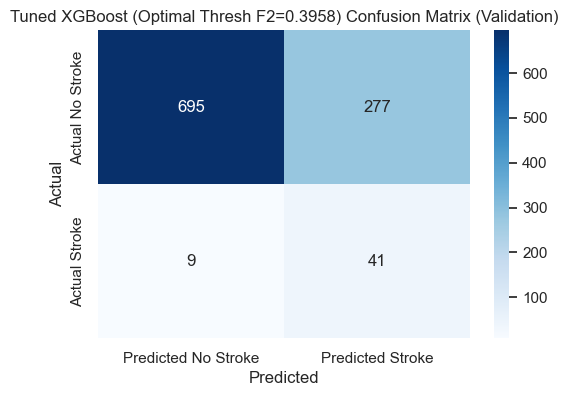

In [57]:
xgb_model_base = xgb.XGBClassifier(random_state=42,
                                   eval_metric='logloss',
                                   scale_pos_weight=scale_pos_weight_value)

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

best_xgb, xgb_run_scores = train_tune_evaluate_model(
    xgb_model_base, xgb_param_grid,
    X_train_final, y_train,
    X_val_final, y_val,
    scorer=f2_scorer,
    model_name_str="XGBoost"
)
model_results_summary.append(xgb_run_scores)

The tuned XGBoost model achieved a respectable **F2-score of 0.3825** during cross-validation. On the validation set, after optimizing its decision threshold to 0.49, it reached an **F2-score of 0.3958**. At this point, it correctly identified 82% of stroke cases (**recall**) with a **precision** of approximately 13%. While its **F2-score** is competitive, its **PR-AUC (0.1461)** and **ROC-AUC (0.8197)** are slightly lower than some other models, suggesting a bit less overall discriminative power or precision-recall balance across all thresholds.

--- LightGBM ---
Starting LightGBM GridSearchCV (5-fold CV)
Fitting 5 folds for each of 48 candidates, totalling 240 fits
GridSearchCV for LightGBM completed in 54.63 seconds.
Best LightGBM params: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 20, 'subsample': 0.7}
Best score (F2 score) from CV: 0.3536

--- Tuned LightGBM (default thresh) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.97      0.85      0.90       972
      Stroke       0.13      0.46      0.21        50

    accuracy                           0.83      1022
   macro avg       0.55      0.65      0.56      1022
weighted avg       0.93      0.83      0.87      1022

F2 Score: 0.3091
PR-AUC: 0.1193
ROC-AUC: 0.7992


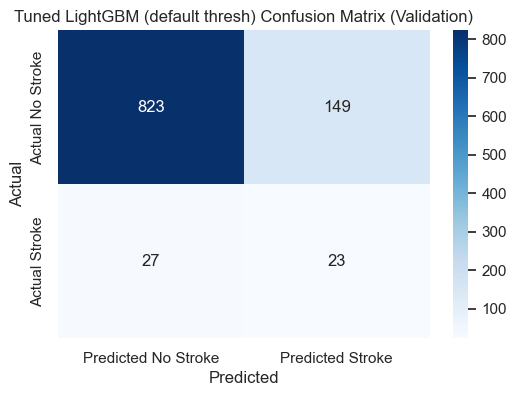

--- LightGBM: Optimizing threshold for F2 on validation set ---
Optimal threshold for LightGBM on validation: 0.14
Max F2-score at this threshold on validation: 0.3920


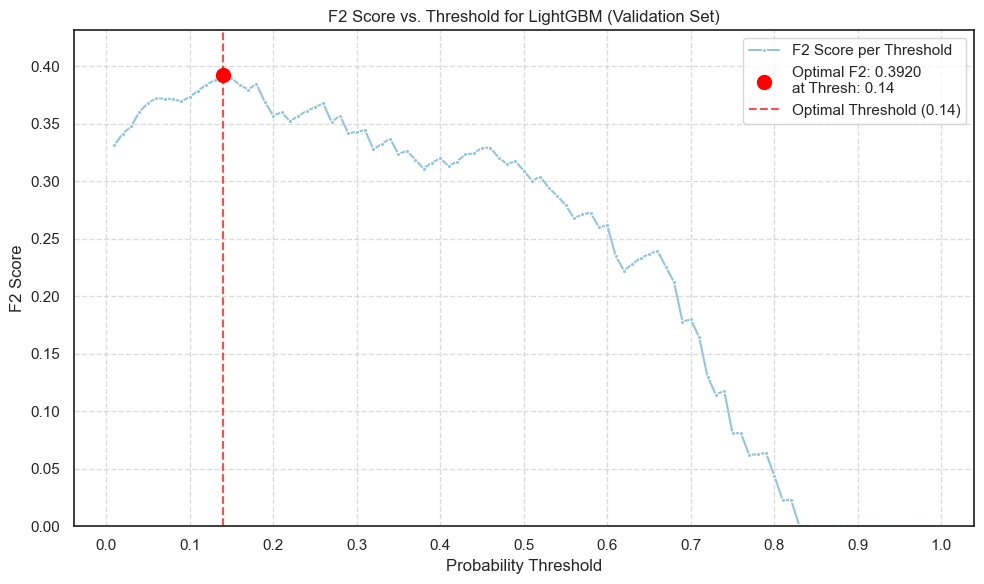

--- Tuned LightGBM (Optimal Thresh F2=0.3920) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.66      0.79       972
      Stroke       0.12      0.90      0.21        50

    accuracy                           0.67      1022
   macro avg       0.56      0.78      0.50      1022
weighted avg       0.95      0.67      0.77      1022

F2 Score: 0.3920
PR-AUC: 0.1193
ROC-AUC: 0.7992


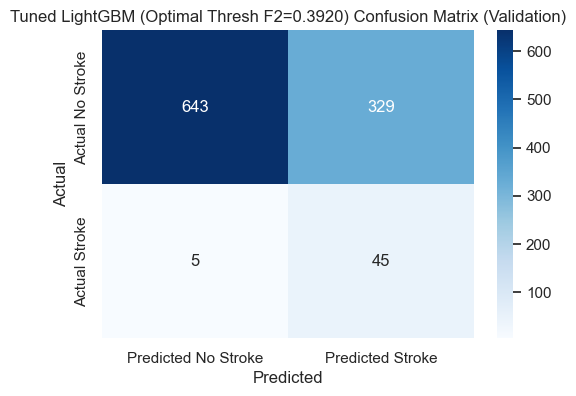

In [58]:
lgbm_model_base = lgb.LGBMClassifier(random_state=42, 
                                     scale_pos_weight=scale_pos_weight_value,
                                     n_jobs=-1, verbosity=-1) 
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

best_lgbm, lgbm_run_scores = train_tune_evaluate_model(
    lgbm_model_base, lgbm_param_grid,
    X_train_final, y_train,
    X_val_final, y_val,
    scorer=f2_scorer,
    model_name_str="LightGBM"
)
model_results_summary.append(lgbm_run_scores)

LightGBM's hyperparameter tuning yielded a cross-validation **F2-score of 0.3536**. A key characteristic of the tuned LightGBM on the validation set was its ability to achieve very high **recall**: by optimizing its threshold to a low 0.14, it identified 90% of stroke cases. This high recall, however, came with the lowest **precision** (12%) among the optimized models, resulting in an **F2-score of 0.3920**. Its **PR-AUC (0.1193)** and **ROC-AUC (0.7992)** were also the lowest of the advanced models, indicating challenges in distinguishing classes with high confidence or maintaining precision.

--- CatBoost ---
Starting CatBoost GridSearchCV (5-fold CV)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
GridSearchCV for CatBoost completed in 15.78 seconds.
Best CatBoost params: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
Best score (F2 score) from CV: 0.3899

--- Tuned CatBoost (default thresh) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.69      0.81       972
      Stroke       0.12      0.86      0.22        50

    accuracy                           0.69      1022
   macro avg       0.56      0.77      0.51      1022
weighted avg       0.95      0.69      0.78      1022

F2 Score: 0.3916
PR-AUC: 0.1776
ROC-AUC: 0.8367


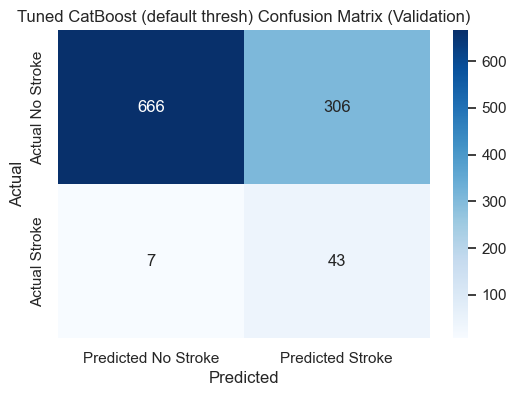

--- CatBoost: Optimizing threshold for F2 on validation set ---
Optimal threshold for CatBoost on validation: 0.59
Max F2-score at this threshold on validation: 0.4111


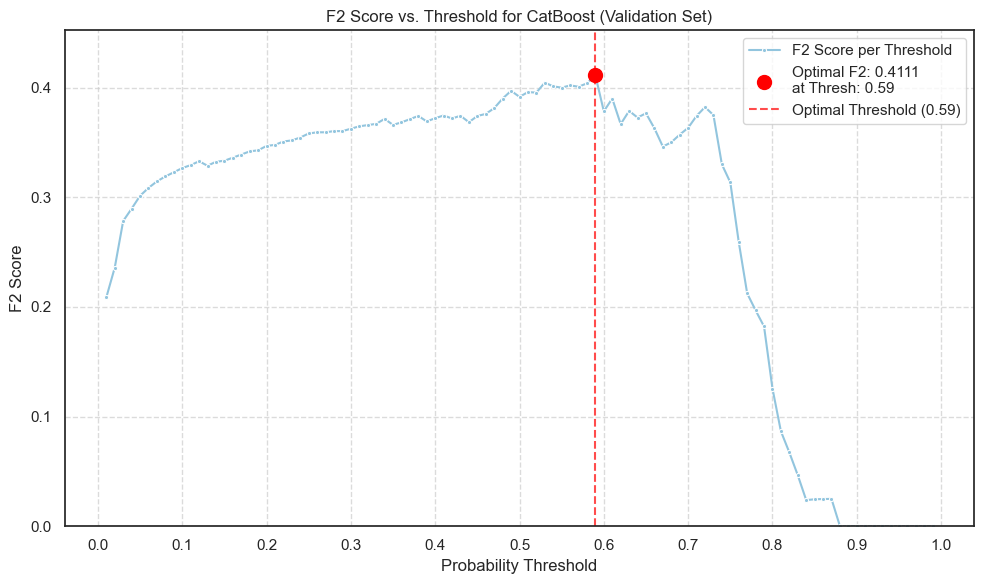

--- Tuned CatBoost (Optimal Thresh F2=0.4111) (Validation Set) ---
              precision    recall  f1-score   support

   No Stroke       0.98      0.78      0.87       972
      Stroke       0.15      0.74      0.25        50

    accuracy                           0.78      1022
   macro avg       0.57      0.76      0.56      1022
weighted avg       0.94      0.78      0.84      1022

F2 Score: 0.4111
PR-AUC: 0.1776
ROC-AUC: 0.8367


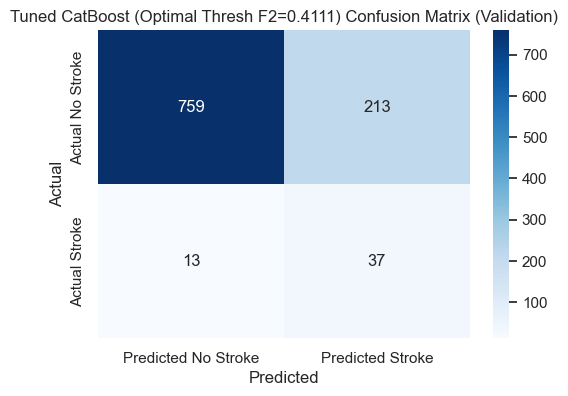

In [59]:
catboost_model_base = cb.CatBoostClassifier(random_state=42, 
                                          auto_class_weights='Balanced',
                                          verbose=0)
catboost_param_grid = {
    'iterations': [100, 200],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5]
}

best_catboost, catboost_run_scores = train_tune_evaluate_model(
    catboost_model_base, catboost_param_grid,
    X_train_final, y_train,
    X_val_final, y_val,
    scorer=f2_scorer,
    model_name_str="CatBoost"
)
model_results_summary.append(catboost_run_scores)

CatBoost demonstrated strong performance, with a cross-validation **F2-score of 0.3899**. After optimizing its decision threshold to 0.59 on the validation set, it achieved the highest **F2-score** among all tested machine learning models: **0.4111**. At this threshold, it balanced a good **recall** of 74% with the best **precision** observed among the optimized advanced models (15%). Furthermore, CatBoost also had the highest **PR-AUC (0.1776)** and **ROC-AUC (0.8367)**, indicating superior overall discriminative ability and a better precision-recall trade-off across thresholds.

In [60]:
final_comparison_table = create_model_comparison_table(model_results_summary)
print("--- Final Model Comparison (Validation Set Metrics) ---")
final_comparison_table

--- Final Model Comparison (Validation Set Metrics) ---


,Model,CV F2 Score (HPO),Val F2 (Default Thresh),Val PR-AUC (Default Thresh),Val ROC-AUC (Default Thresh),Val Optimal F2 Threshold,Val F2 (Optimal Thresh),Val Recall (Optimal Thresh),Val Precision (Optimal Thresh)
3,CatBoost,0.389864,0.391621,0.177642,0.836656,0.59,0.411111,0.74,0.148000
0,RandomForest,0.329765,0.320122,0.153435,0.824959,0.34,0.400802,0.80,0.133779
1,XGBoost,0.382509,0.389864,0.146080,0.819671,0.49,0.395753,0.82,0.128931
2,LightGBM,0.353584,0.309140,0.119265,0.799156,0.14,0.391986,0.90,0.120321


The table above summarizes the performance of all tuned machine learning models on the validation set, alongside their **F2-scores** achieved during cross-validation hyperparameter tuning.

- Best **F2-Score** (Optimal Threshold): CatBoost leads with an F2-score of 0.4111, followed closely by RandomForest (0.4008), XGBoost (0.3958), and LightGBM (0.3920). This indicates that after threshold optimization, all advanced models achieve a similar level of performance based on the primary F2 metric.

- **Recall vs. Precision** Trade-off: LightGBM achieved the highest **recall** (90%) but at the cost of the lowest **precision** (12%). CatBoost provided a more balanced outcome with 74% **recall** and the highest **precision** (14.8%) among this group at its optimal F2 threshold.

- **AUC** Metrics: CatBoost also shows the best **PR-AUC (0.1776)** and **ROC-AUC (0.8367)**, suggesting it has the strongest ability to distinguish between `stroke` and `non-stroke` patients across various decision thresholds.

- Comparison with Baselines: 
    - All advanced ML models significantly outperform the Dummy Classifier's **F2-score (0.0826)**.
    - The initial simple rule-based model achieved an **F2-score of 0.3292**.
    - The Logistic Regression model achieved an **F2-score of 0.4032**.

As a final decision, the CatBoost model will be trained for the final model. It will be retrained on the full data (train + validation).

### 5.3 Training the final model

In [61]:
X_train_val_combined_final = pd.concat([X_train_final, X_val_final], 
                                       ignore_index=False)
y_train_val_combined = pd.concat([y_train, y_val], ignore_index=False)
print("Shape of combined training data (X_train_val_combined_final):",
      X_train_val_combined_final.shape)

Shape of combined training data (X_train_val_combined_final): (4087, 22)


Retraining final CatBoost model on combined X_train + X_val data

In [62]:
final_catboost_model = cb.CatBoostClassifier(
     **best_catboost.get_params()
)
final_catboost_model.fit(X_train_val_combined_final, y_train_val_combined)

Saving the final model to a .pkl file for deployment.

In [63]:
final_model_path = os.path.join(ARTIFACTS_DIR_NB, 'final_stroke_model.pkl')
with open(final_model_path, 'wb') as f_mod:
    pickle.dump(final_catboost_model, f_mod)
print(f"Final CatBoost model saved to {final_model_path}")

Final CatBoost model saved to c:\Users\IT\Desktop\M3S2 task\artifacts\final_stroke_model.pkl


Evaluating the final model on the held-out test set and saving the optimal threshold for deployment.

Optimal threshold saved to c:\Users\IT\Desktop\M3S2 task\artifacts\optimal_threshold.pkl

--- Final CatBoost Model (Test Set) ---
              precision    recall  f1-score   support

   No Stroke       0.99      0.77      0.86       972
      Stroke       0.15      0.80      0.25        50

    accuracy                           0.77      1022
   macro avg       0.57      0.78      0.56      1022
weighted avg       0.95      0.77      0.83      1022

F2 Score: 0.4283
PR-AUC: 0.2567
ROC-AUC: 0.8429


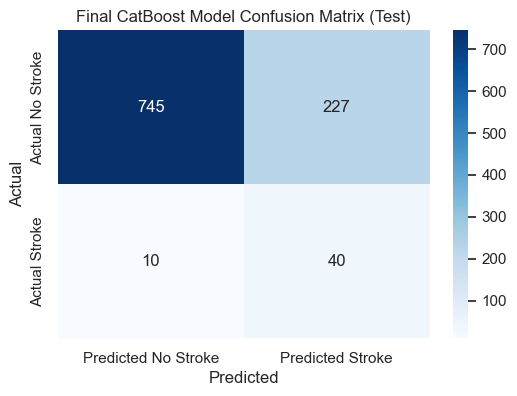


--- Summary of Final CatBoost Model on TEST SET ---
Selected Optimal Threshold (from validation): 0.59
F2 Score: 0.4283
Recall (Stroke): 0.8000
Precision (Stroke): 0.1498
PR-AUC: 0.2567
ROC-AUC: 0.8429


In [64]:
optimal_threshold_catboost = 0.59

optimal_threshold_path = os.path.join(ARTIFACTS_DIR_NB, 'optimal_threshold.pkl')
with open(optimal_threshold_path, 'wb') as f_thresh:
    pickle.dump(optimal_threshold_catboost, f_thresh)
print(f"Optimal threshold saved to {optimal_threshold_path}\n")

evaluate_final_model_performance(final_catboost_model, X_test_final, 
                                 y_test, optimal_threshold_catboost, 
                                 model_name="Final CatBoost Model",
                                 dataset_name="Test")

The final selected model, **CatBoost** (retrained on the combined training and validation data using its best hyperparameters), was evaluated on the held-out test set. Using the optimal decision threshold of 0.59 the model achieved:

- An **F2-score of 0.4283**. This is the primary metric, and this score indicates the model's effectiveness in prioritizing the detection of stroke cases.
- A **Recall of 0.8** for the stroke class, meaning it successfully identified 80% of the actual stroke patients in the test set. This aligns well with the goal of minimizing missed diagnoses.
- A **Precision of 0.15** for the stroke class. This indicates that when the model predicts a stroke, about 15% of those predictions are correct, while the rest are false positives. This highlights the trade-off made to achieve high recall.
- The **PR-AUC was 0.2567** and the **ROC-AUC was 0.8429**. These AUC scores suggest a good ability of the model to distinguish between stroke and non-stroke patients across various thresholds, with the PR-AUC being particularly relevant for this imbalanced dataset.

Overall, the model demonstrates a strong capability to identify a large majority of stroke cases on unseen data, which was the primary objective. The precision indicates that there will be a notable number of false alarms, a known trade-off when optimizing for high recall in such a critical medical application.

### 5.4 SHAP Value Analysis for Final CatBoost Model

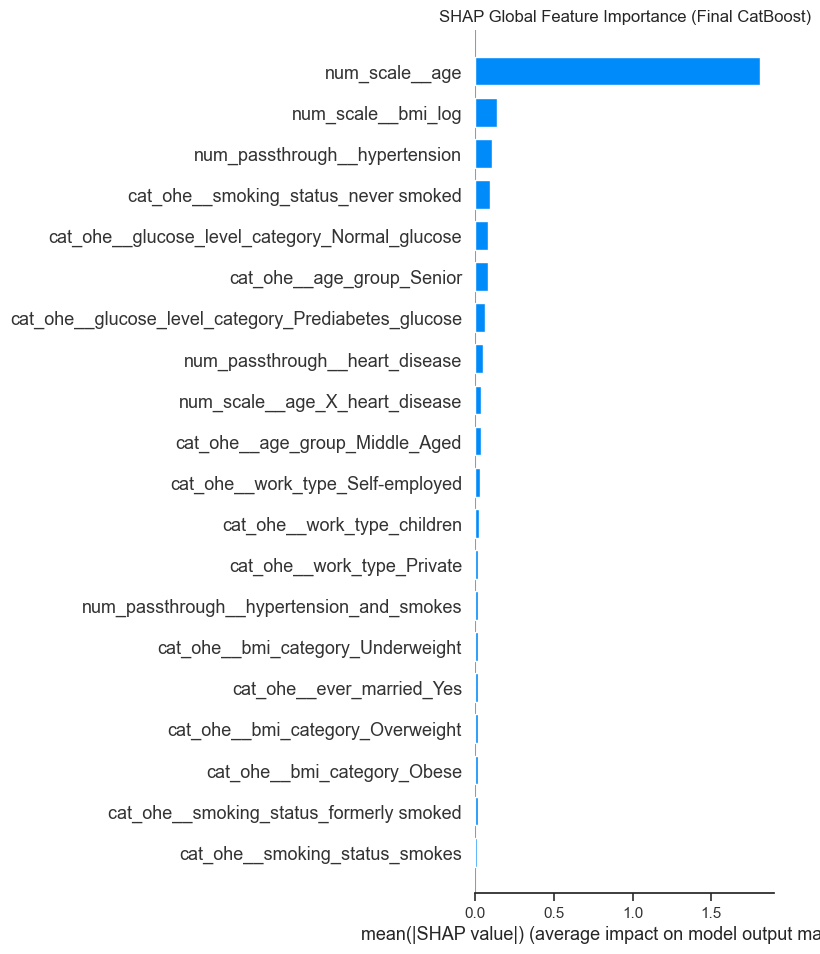

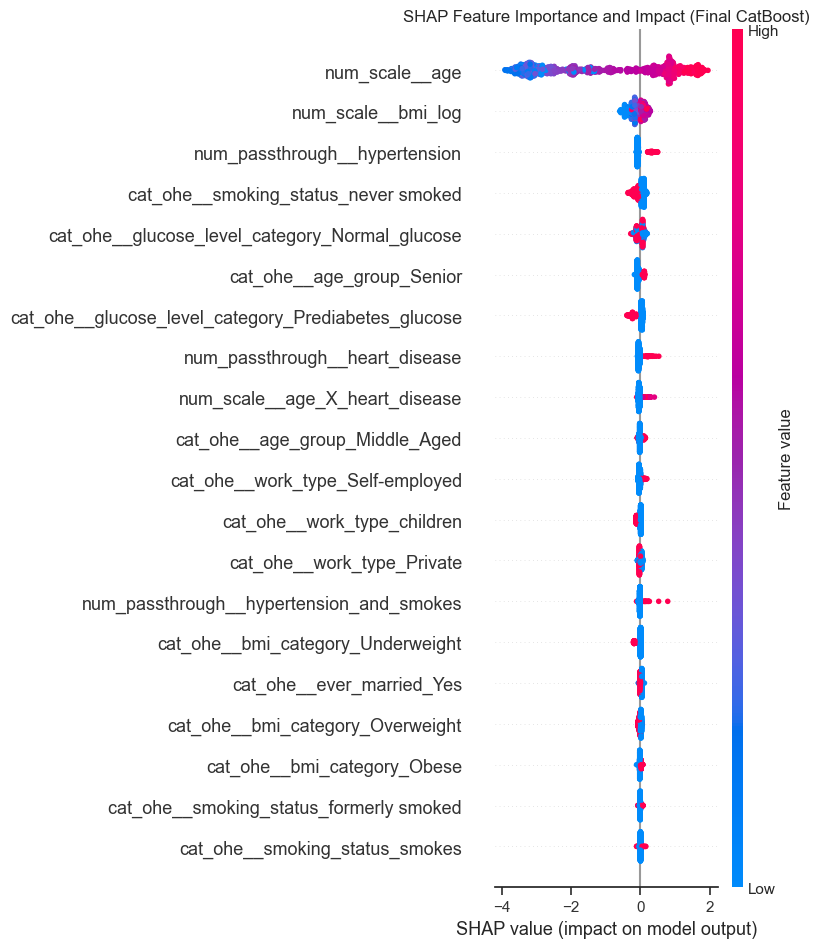

In [65]:
explainer = shap.TreeExplainer(final_catboost_model)

shap_values = explainer.shap_values(X_test_final)
shap.summary_plot(shap_values, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Final CatBoost)")
plt.show()

shap.summary_plot(shap_values, X_test_final, show=False)
plt.title("SHAP Feature Importance and Impact (Final CatBoost)")
plt.show()

- The CatBoost model relies heavily on `age` as the primary driver of stroke risk prediction. Log-transformed `BMI` and `hypertension` are the next most influential factors.
- Specific categories like `never having smoked`, `having normal glucose levels`, and being in the `senior age group` have clear and significant impacts (either risk-increasing or risk-decreasing).
- The engineered features (like `age_group_Senior`, `glucose_level_category_Normal_glucose`) are indeed being used effectively by the model.
- Many of the one-hot encoded categories from `work_type` or some s`moking_status` have a smaller overall impact, suggesting they are secondary factors.

### 5.5 Summary of Model Selection and Evaluation

- **Baseline Performance**:
    - Three baselines were established: a Dummy (Stratified) Classifier (**F2-score: 0.0826**), a Simple Rule-Based Predictor (**F2-score: 0.3292**), and a Logistic Regression model (**F2-score: 0.4032** after VIF-based feature reduction for this model).
    - The Logistic Regression model provided a strong F2-score and also demonstrated good overall discriminative power with a **PR-AUC of 0.1630** and **ROC-AUC of 0.8227**, outperforming the simpler baselines.

- **Advanced Model Training and Tuning**:
    - Four advanced models were considered: RandomForest, XGBoost, LightGBM, and CatBoost.
    - Hyperparameter tuning for each was done using 5-fold stratified cross-validation on the training set (X_train_final), with the f2_scorer as the optimization metric in GridSearchCV.
    - For each tuned model, performance was assessed on the validation set (X_val_final), first using the default 0.5 prediction threshold, and then by determining an optimal threshold to maximize its F2-score.

- **Model Comparison on Validation Set**:
    - After optimizing decision thresholds for F2-score, CatBoost emerged as the top-performing machine learning model, achieving an **F2-score of 0.4111**, a **recall** of 0.74, and a **precision** of 0.1480. It also exhibited the highest **PR-AUC (0.1776)** and **ROC-AUC (0.8367)** among the advanced models.
    - RandomForest (**F2: 0.4008**), XGBoost (**F2: 0.3958**), and LightGBM (**F2: 0.3920**, highest **recall** of 0.90 but lowest **precision**) also showed competitive F2-scores after threshold optimization.

## 6. Results & Key Findings

### 6.1 Final Model Performance

- **Final Model Selection and Test Set Evaluation**:
    - CatBoost was selected as the final model due to its superior performance on the validation set, particularly its leading F2-score and strong AUC metrics.
    - The chosen CatBoost model (with its best hyperparameters: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 3, 'learning_rate': 0.05}) was retrained on the combined training and validation data.
    - Evaluated on the completely unseen test set, using the optimal threshold of 0.59, the final CatBoost model achieved:
        - **F2-Score: 0.4283**
        - **Recall (Stroke): 0.8**
        - **Precision (Stroke): 0.1498**
        - **PR-AUC: 0.2567**
        - **ROC-AUC: 0.8429**
    - The performance on the test set was consistent with, and even slightly better in terms of F2 and PR-AUC than, the validation set results, indicating good generalization. The model successfully identified 80% of stroke cases in the test set.

- **Model Interpretability (SHAP Analysis)**:
    - SHAP value analysis on the final CatBoost model revealed that `age` is the most influential predictor, followed by `log-transformed BMI`, and `hypertension`.
    - Engineered categorical features such as `age_group_Senior` and `glucose_level_category_Normal_glucose`, along with `smoking_status_never smoked`, also showed significant impact, confirming the value of the feature engineering steps.

### 6.2 Answering Goals and Addressing Stakeholder Needs

- For **Medical Doctors & Clinicians**:
    - The developed **CatBoost** model achieved an **F2-score of 0.4283** and a **recall** of 0.8 for `stroke` on unseen data. This indicates its potential to assist in identifying 80% of high-risk individuals who might benefit from further assessment or preventative strategies."
    - The key identified risk factors (`age`, `bmi`, `hypertension`) align with existing medical knowledge and can reinforce patient counseling."

- **For Hospital Administration**:
    - `"This predictive tool, by flagging high-risk patients with 80% recall, could contribute to earlier interventions, potentially reducing the severity of strokes and improving long-term patient outcomes. The precision of 15% means that for every ~7 patients flagged, one is a high true risk, a trade-off considered acceptable given the severity of missing a stroke."

- **For Patients and their Families**:
    - Early identification through such a model could provide patients deemed high-risk with crucial time to discuss preventative measures with their doctors and prepare for potential emergencies.

- **For Public Health Researchers**:
    - The feature importance analysis (e.g., the significant impact of `age` or `hypertension`) provides data-driven insights that can contribute to broader stroke prevention research."

## 7. Limitations and Future Improvements

**Limitations**:
- Missing `BMI` was imputed; actual `BMI` might yield different results.
- "Unknown" smoking status limits full analysis of smoking impact.

**Future Improvements**:
- Collect More Data: Larger, more diverse datasets.
- Refine Feature Engineering: Explore more complex interactions, especially those hinted at by SHAP or domain experts.
- Advanced Imputation: More sophisticated methods for missing BMI if it remains a concern.
- External Validation: Test the model on data from a different hospital or population.